# Машинное обучение в бизнесе. Выбор локации для скважины

**Описание проекта:**

Необходимо решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:

* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски необходимо с помощью техники *Bootstrap*.

**Цель исследования:**

Построить модель для определения региона, где добыча принесёт наибольшую прибыль

**Условия задачи:**

* Для обучения модели подходит только линейная регрессия;
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Детали контрактов и характеристики месторождений не разглашаются.

**Ход исследования:**

* загрузка данных;
* предобработка данных;
* исследовательский анализ данных;
* корреляционный анализ;
* обучение моделей;
* подготовка к расчёту прибыли;
* функция для расчёта прибыли;
* расчёт рисков и прибыли для каждого региона;
* выводы

**Признаковое описание данных:**

* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек;
* `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка данных

In [1]:
#импортируем необходимые библиотеки
!pip install --upgrade -q scikit-learn
!pip install --upgrade -q phik
!pip install optuna -q
!pip install optuna-integration -q

import os

import pandas as pd
import numpy as np

import textwrap

import phik

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
                                  
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import ElasticNet

import optuna
from optuna import distributions

from sklearn.metrics import (make_scorer,
                             mean_squared_error)

import matplotlib.pyplot as plt
import seaborn as sns

Сохраним ключевые характеристики для расчётов в разделе 6 `Подготовка к расчёту прибыли` в отдельные переменные:
* `BUDGET`: бюджет на разработку скважин в регионе;
* `INCOME_MBBLS`: доход с единицы продукта (одна тысяча баррелей);
* `SAMPLE_WELLS`, `BEST_WELLS`: количество разведываемых и отобранных после разведки скважин соответственно;
* `BOOTSTRAP_SAMPLES`:  количество выборок для бутстрепа;
* `ALPHA`: 95%-й доверительный интервал

In [2]:
BUDGET = 10_000_000_000
INCOME_MBBLS = 450_000
SAMPLE_WELLS = 500
BEST_WELLS = 200
BOOTSTRAP_SAMPLES = 1000
ALPHA = 0.025

In [3]:
#настроим отображение графиков
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
#считываем файлы
pthA_1 = '/datasets/geo_data_0.csv'
pthA_2 = 'geo_data_0.csv'

pthB_1 = '/datasets/geo_data_1.csv'
pthB_2 = 'geo_data_1.csv'

pthC_1 = '/datasets/geo_data_2.csv'
pthC_2 = 'geo_data_2.csv'


if os.path.exists(pthA_1):
    region_a = pd.read_csv(pthA_1)
elif os.path.exists(pthA_2):
    region_a = pd.read_csv(pthA_2)
else:
    print('Something is wrong with file geo_data_0.csv')
    
if os.path.exists(pthB_1):
    region_b = pd.read_csv(pthB_1)
elif os.path.exists(pthB_2):
    region_b = pd.read_csv(pthB_2)
else:
    print('Something is wrong with file geo_data_1.csv')

if os.path.exists(pthC_1):
    region_c = pd.read_csv(pthC_1)
elif os.path.exists(pthC_2):
    region_c = pd.read_csv(pthC_2)
else:
    print('Something is wrong with file geo_data_2.csv')

In [5]:
#посмотрим на данные в файле region_a
region_a.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Названия столбцов находятся в корректном формате, также как и разделители в числовых значениях. Переименуем столбец с таргетом для удобства, чтобы не забыть единицы измерения

In [6]:
region_a.rename(columns={'product': 'product_mbbls'}, inplace=True)

In [7]:
#посмотрим на данные в файле region_b
region_b.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Названия столбцов находятся в корректном формате, также как и разделители в числовых значениях. Переименуем столбец с таргетом для удобства, чтобы не забыть единицы измерения

In [8]:
region_b.rename(columns={'product': 'product_mbbls'}, inplace=True)

In [9]:
#посмотрим на данные в файле region_c
region_c.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Названия столбцов находятся в корректном формате, также как и разделители в числовых значениях. Переименуем столбец с таргетом для удобства, чтобы не забыть единицы измерения

In [10]:
region_c.rename(columns={'product': 'product_mbbls'}, inplace=True)

Необходимые библиотеки импортированы, данные загружены. Названия колонок соответствуют каноническому виду, как и разделители во всех трёх датафреймах. Для удобства переименовали названия столбцов с таргетом

## Предобработка данных

In [11]:
#функция, возвращающая базовую информацию о датафрейме
def df_basic_info(df):
    #df - датафрейм
    
    print(f'Названия столбцов\n\n{df.columns}')
    print('----------------------------------------------------------------')
    print(f'Основные параметры данных\n\n{df.columns}')
    df.info()
    print('----------------------------------------------------------------')
    print(f'Число уникальных значений признаков\n\n{df.nunique()}')
    print('----------------------------------------------------------------')
    print(f'Типы данных\n\n{df.dtypes.value_counts()}')
    print('----------------------------------------------------------------')
    print(f'Размер датафрейма\n\n{df.shape}')
    print('----------------------------------------------------------------')
    print(f'Базовые статистики\n\n{df.describe()}')
    print('----------------------------------------------------------------')
    print(f'Доля пропущенных значений\n\n{df.isna().mean().sort_values()}')
    print('----------------------------------------------------------------')
    print(f'Количество полных дубликатов\n\n{df.duplicated().sum()}')
    print('----------------------------------------------------------------')
    return df.head(10)

### region_a

In [12]:
df_basic_info(region_a)

Названия столбцов

Index(['id', 'f0', 'f1', 'f2', 'product_mbbls'], dtype='object')
----------------------------------------------------------------
Основные параметры данных

Index(['id', 'f0', 'f1', 'f2', 'product_mbbls'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             100000 non-null  object 
 1   f0             100000 non-null  float64
 2   f1             100000 non-null  float64
 3   f2             100000 non-null  float64
 4   product_mbbls  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------------------
Число уникальных значений признаков

id                99990
f0               100000
f1               100000
f2               100000
product_mbbls    100000
dtype: int64
------------------------------------------------

,id,f0,f1,f2,product_mbbls
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Отметим, что в данных отсутствуют полные дубликаты и пропуски. Однако видно, что существуют записи с различными значениями признаков и таргета, но одинаковым `id`. Выведем этии записи, отсортировав по значению идентификатора

In [13]:
region_a[region_a.duplicated(subset=['id'],
                             keep=False)].sort_values(by='id').head(20)

,id,f0,f1,f2,product_mbbls
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Видим, что есть 10 пар записей с одинаковым `id`, но разными значениями признаков и таргета. С учётом того, что мы не знаем, что из себя представляют признаки, нельзя исключать, что их значения могут изменяться для одной и той же скважины. При этом достоверно не известны даты, когда были оценены объёмы нефти в скважине. С учётом вышеотмеченного, а также того, что объём нефти в скважине может со временем как увеличиваться, так и снижаться, нельзя однозначно утверждать, какая из записей для каждой из выбранных скважин более актуальная и достоверная. Соответственно, нельзя удалить какие-то записи для отмеченных 10 скважин. Однако на всякий случай сохраним `id` отмеченных скважин в переменную `a_dupl_id`

In [14]:
a_dupl_id = region_a[region_a.duplicated(subset=['id'],
                             keep=False)].sort_values(by='id')['id'].unique()

С учётом того, что значения во всех столбцах, кроме `id`, уникальны, неявные дубликаты отсутствуют.

Анализ базовых статистик количественных признаков и таргета не выявил каких-либо аномалий (за исключением того, что присутствуют скважины с нулевым объёмом нефти). Более полно изучим данные в разделе с EDA.

### region_b

In [15]:
df_basic_info(region_b)

Названия столбцов

Index(['id', 'f0', 'f1', 'f2', 'product_mbbls'], dtype='object')
----------------------------------------------------------------
Основные параметры данных

Index(['id', 'f0', 'f1', 'f2', 'product_mbbls'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             100000 non-null  object 
 1   f0             100000 non-null  float64
 2   f1             100000 non-null  float64
 3   f2             100000 non-null  float64
 4   product_mbbls  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------------------
Число уникальных значений признаков

id                99996
f0               100000
f1               100000
f2               100000
product_mbbls        12
dtype: int64
------------------------------------------------

,id,f0,f1,f2,product_mbbls
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Видим, что в данных отсутствуют пропуски и явные дубликаты.  Однако, как и в прошлом датафрейме, существуют записи с различными значениями признаков и таргета, но одинаковым `id`. Выведем эти записи, отсортировав по значению идентификатора

In [16]:
region_b[region_b.duplicated(subset=['id'],
                             keep=False)].sort_values(by='id').head(10)

,id,f0,f1,f2,product_mbbls
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Видим, что есть 4 пары записей с одинаковым `id`, но разными значениями признаков и таргета. По аналогии с прошлым датафреймом не будем удалять какие-то из этих записей для отмеченных 4 скважин. На всякий случай сохраним `id` отмеченных скважин в переменную `b_dupl_id`

In [17]:
b_dupl_id = region_b[region_b.duplicated(subset=['id'],
                             keep=False)].sort_values(by='id')['id'].unique()

Также стоит отметить, что по каким-то причинам для 100000 записей всего 12 уникальных значений таргета. Посмотрим на них

In [18]:
region_b['product_mbbls'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product_mbbls, dtype: int64

Различные значения таргета распределены достаточно равномерно; при этом одну из долей занимают скважины с нулевым объёмом нефти.

С учётом того, что значения во всех столбцах, кроме `id` и `product_mbbls`, уникальны, неявные дубликаты отсутствуют.

Анализ базовых статистик количественных признаков и таргета не выявил каких-либо аномалий (за исключением того, что присутствуют скважины с нулевым объёмом нефти и всего лишь 12 уникальных значений таргета на 100000 записей). Более полно изучим данные в разделе с EDA.

### region_c

In [19]:
df_basic_info(region_c)

Названия столбцов

Index(['id', 'f0', 'f1', 'f2', 'product_mbbls'], dtype='object')
----------------------------------------------------------------
Основные параметры данных

Index(['id', 'f0', 'f1', 'f2', 'product_mbbls'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             100000 non-null  object 
 1   f0             100000 non-null  float64
 2   f1             100000 non-null  float64
 3   f2             100000 non-null  float64
 4   product_mbbls  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------------------
Число уникальных значений признаков

id                99996
f0               100000
f1               100000
f2               100000
product_mbbls    100000
dtype: int64
------------------------------------------------

,id,f0,f1,f2,product_mbbls
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Видим, что в данных отсутствуют пропуски и явные дубликаты.  Однако, как и в прошлых датафреймах, существуют записи с различными значениями признаков и таргета, но одинаковым `id`. Выведем эти записи, отсортировав по значению идентификатора

In [20]:
region_c[region_c.duplicated(subset=['id'],
                             keep=False)].sort_values(by='id').head(20)

,id,f0,f1,f2,product_mbbls
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Видим, что есть 4 пары записей с одинаковым `id`, но разными значениями признаков и таргета. По аналогии с прошлыми датафреймами не будем удалять какие-то из этих записей для отмеченных 4 скважин. На всякий случай сохраним `id` отмеченных скважин в переменную `c_dupl_id`

In [21]:
c_dupl_id = region_c[region_c.duplicated(subset=['id'],
                             keep=False)].sort_values(by='id')['id'].unique()

С учётом того, что значения во всех столбцах, кроме `id`, уникальны, неявные дубликаты отсутствуют.

Анализ базовых статистик количественных признаков и таргета не выявил каких-либо аномалий (за исключением того, что присутствуют скважины с нулевым объёмом нефти). Более полно изучим данные в разделе с EDA.

Таким образом, в данном разделе была проведена первичная предобработка данных. Установлено, что во всех трёх датафреймах (в каждом по 100000 записей) отсутствуют пропуски, явные и неявные дубликаты. При этом в каждом из трёх датафреймов имеются записи с различными значениями признаков и таргета, но одинаковым `id`. Ввиду того, что нет возможности точно узнать природу данного факта (ошибка в заполнении данных/данные об одних и тех же скважинах в разные периоды времени/etc), было принято решение на данном этапе не удалять какие-то из отмеченных записей; при этом `id` выделенных записей были сохранены.

Кроме того, в датафрейме `region_b` для 100000 имеющихся записей о различных скважинах наблюдается всего лишь 12 уникальных значений таргета, чего не наблюдается в остальных датафреймах. Более подробно данная особенность будет разобрана в разделе с EDA.

Типы данных в столбцах соответствуют ожидаемым. Для целочисленных значений можно было бы осуществить изменение типа данных с `float64` на `float32` или `float16`, однако ввиду небольшого объёма памяти в данном случае в этом нет необходимости.

Анализ базовых статистик количественных признаков и таргета не выявил каких-либо аномалий (за исключением того, что присутствуют скважины с нулевым объёмом нефти). Более полно данные будут проанализированы в разделе с EDA

## Исследовательский анализ данных

In [22]:
#функция для корректной отрисовки названий столбцов
def wrap_labels(ax, width, break_long_words=False):
    #ax - график
    #width - ширина строки
    
    #создание списка названий столбцов c заданной шириной строки
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_xticks(ax.get_xticks(), labels=labels)

In [23]:
#функция для анализа категориальных признаков
def cat_feat_analysis(df, feat, df_name):
    #df - датафрейм
    #feat - категориальный признак
    #df_name - название датафрейма
    
    #отрисовка упорядоченной столбчатой диаграммы
    fig, ax = plt.subplots()
    print(f'Уникальные значения\n\n{df[feat].value_counts(normalize=True)}')
    print('-----------------------------------------------------')
    print(f'Базовые статистики\n\n{df[feat].describe()}')
    print('-----------------------------------------------------')
    sns.countplot(data=df,
                  x=feat,
                  order = df[feat].value_counts().index,
                  hue=feat,
                  legend=False,
                  palette='pastel',
                  ax=ax).set(title=f'Распределение признака {feat}\n'
                                   f'в датафрейме {df_name}', 
                             ylabel='Количество скважин')
    plt.xticks(rotation=90)
                        
    
    #корректировка длины названия столбца
    wrap_labels(ax, 10)
    ax.figure

In [24]:
#функция для анализа количественных признаков
def quant_feat_analysis(df, feat, df_name):
    #df - датафрейм
    #feat - количественный признак
    #df_name - название датафрейма
    
    print(f'Базовые статистики\n\n{df[feat].describe()}')
    print('-----------------------------------------------------')
    fig, (ax_box, ax_hist) = plt.subplots(2,
                                          sharex=True,
                                          gridspec_kw = {'height_ratios': (.1, .9)})
    #отрисовка боксплота
    sns.boxplot(data=df, 
                x=feat,
                color='cadetblue',
                ax=ax_box)
    
    #отрисовка гистограммы
    sns.histplot(data=df,
                 x=feat,
                 bins=round(1 + np.log2(df.shape[0])),
                 kde=True,
                 color='cadetblue',
                 ax=ax_hist)
    
    ax_box.set(xlabel = '') 
    ax_box.set(title=f'Распределение признака {feat}\n в датафрейме {df_name}') 
    ax_hist.set(xlabel=feat)
    ax_hist.set(ylabel='Количество скважин')
    
    plt.show()

Для удобства восприятия и сравнения распределений будем рассматривать одни и те же признаки сразу для всех датафреймов совместно

### id

В предыдущем разделе было установлено, что во всех датафреймах подавляющее большинство идентификаторов - уникальные значения, однако присутствует небольшое количество (не более 10) значений, совпадающих для двух записей

### f0

Базовые статистики

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64
-----------------------------------------------------


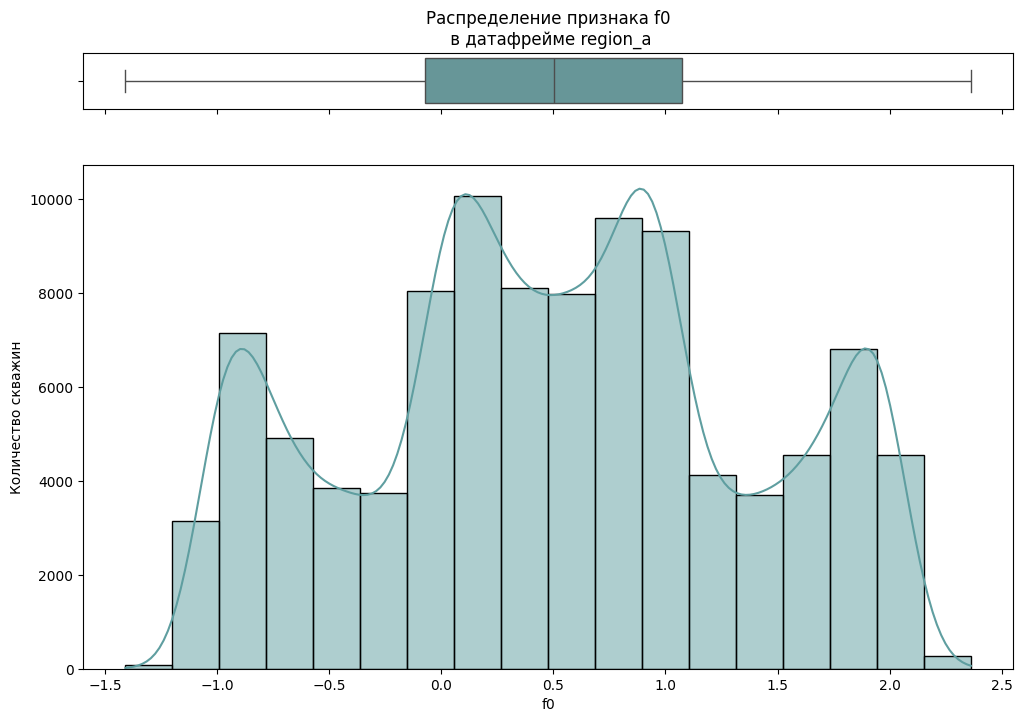

In [25]:
#признак f0 датафрейма region_a
quant_feat_analysis(region_a, 'f0', 'region_a')

Базовые статистики

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64
-----------------------------------------------------


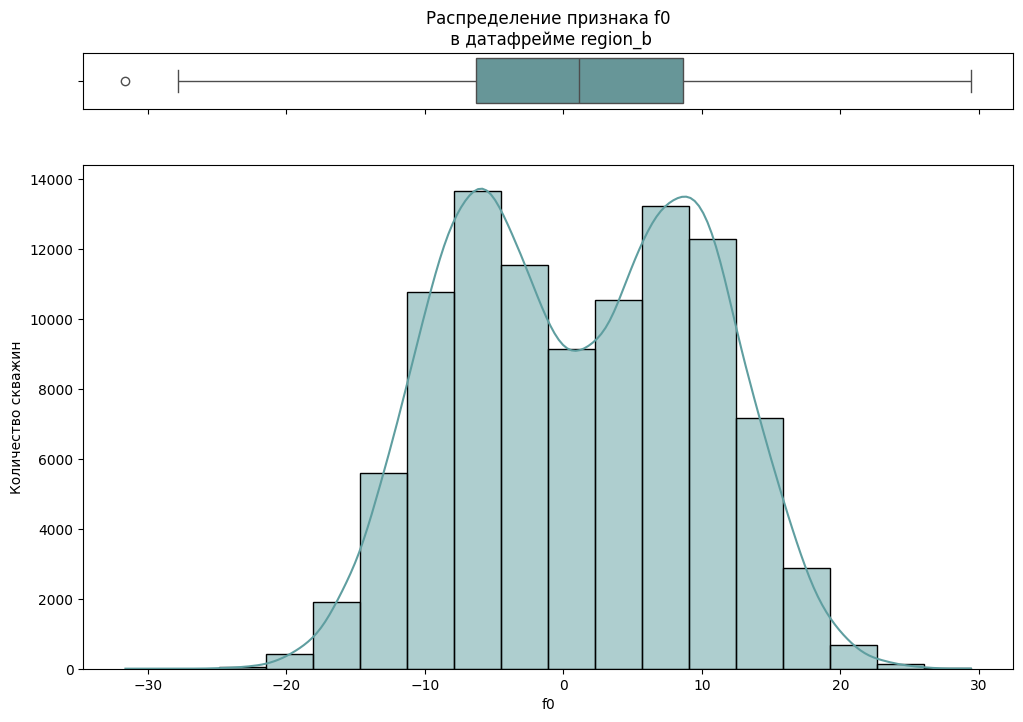

In [26]:
#признак f0 датафрейма region_b
quant_feat_analysis(region_b, 'f0', 'region_b')

Базовые статистики

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64
-----------------------------------------------------


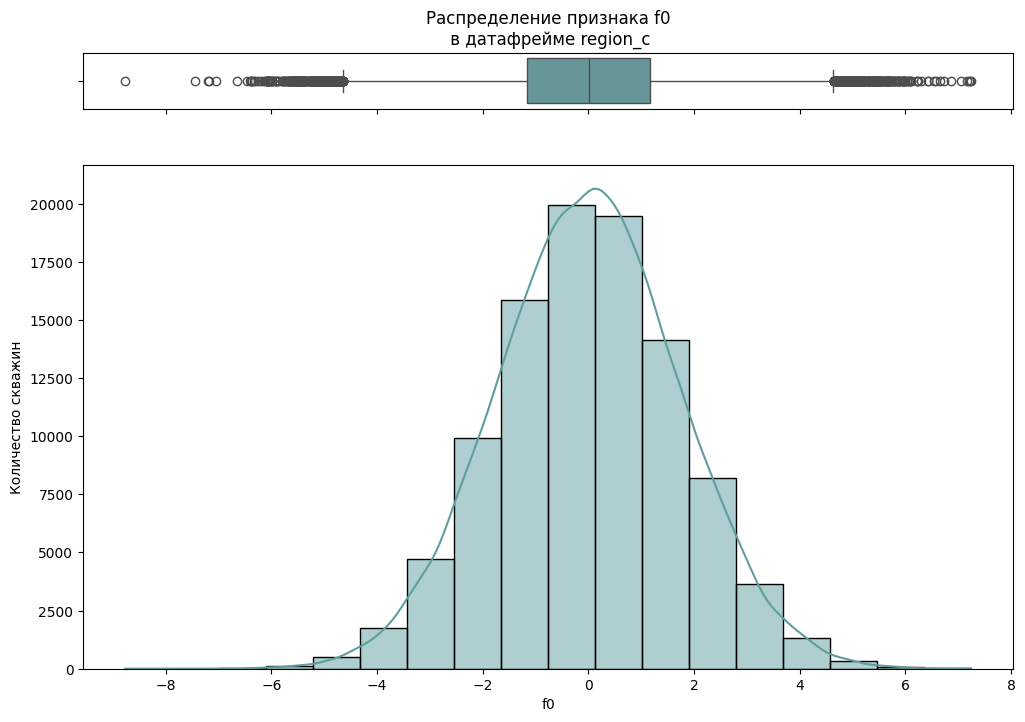

In [27]:
#признак f0 датафрейма region_c
quant_feat_analysis(region_c, 'f0', 'region_c')

Распределения признака `f0` в трёх датафреймах имеют различную структуру. Для датафреймов `region_a` и `region_b` наблюдаем полимодальные распределения (для певрвого можно выделить 3 или 4 моды в зависимости от интерпретации, для второго - 2), для датафрейма `region_c` - мономодальное распределение, имеющее структуру нормального. 

При этом стоит отметить, что для всех датафреймов область значений признака значительно различается - размах признака для датафрейма `region_a` примерно в 15 раз меньше в сравнении с датафреймом `region_b` и примерно в 4 раза меньше в сравнении с датафрйемом `region_c`. При этом явных выбросов и аномальных значений не наблюдается ни в одном из датафреймов - отмеченные боксплотами выбросы в датафреймах `region_b` и `region_c` удалять не будем ввиду не очень сильного отклонения от "усов" боксплотов.

Для каждого из трёх датафреймов не наблюдается смещения признака в какую-либо область - медианы и средние имеют достаточно близкие значения. При этом разброс данных статистик между разными датафреймами больше и может достигать значения интерквартильного размаха для датафрейма `region_a` 

### f1

Базовые статистики

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64
-----------------------------------------------------


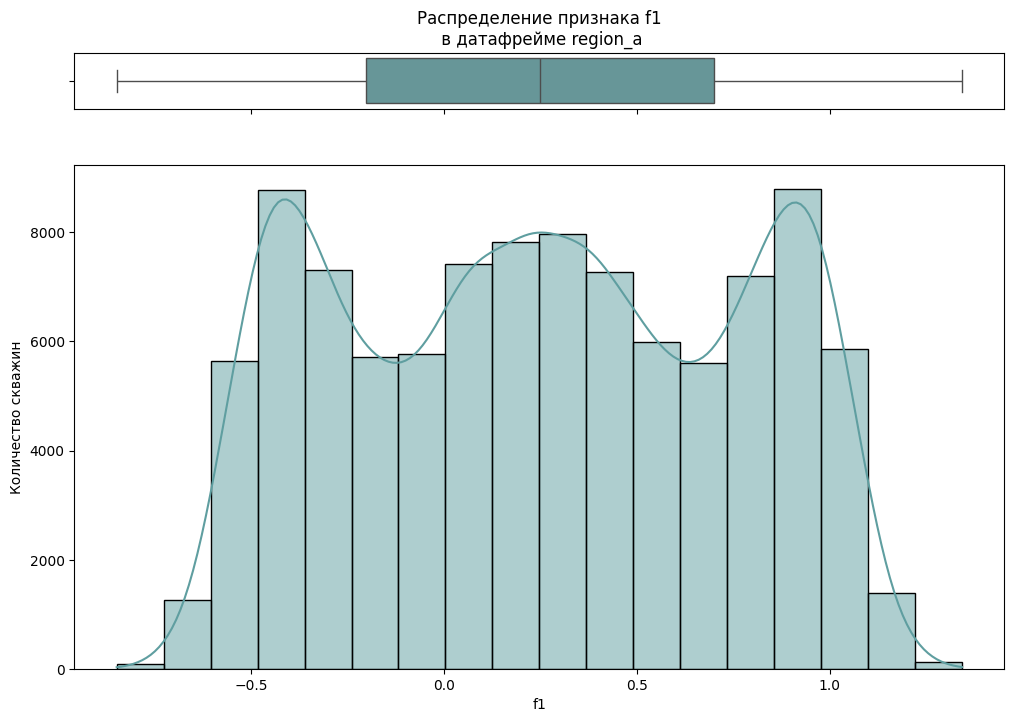

In [28]:
#признак f1 датафрейма region_a
quant_feat_analysis(region_a, 'f1', 'region_a')

Базовые статистики

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64
-----------------------------------------------------


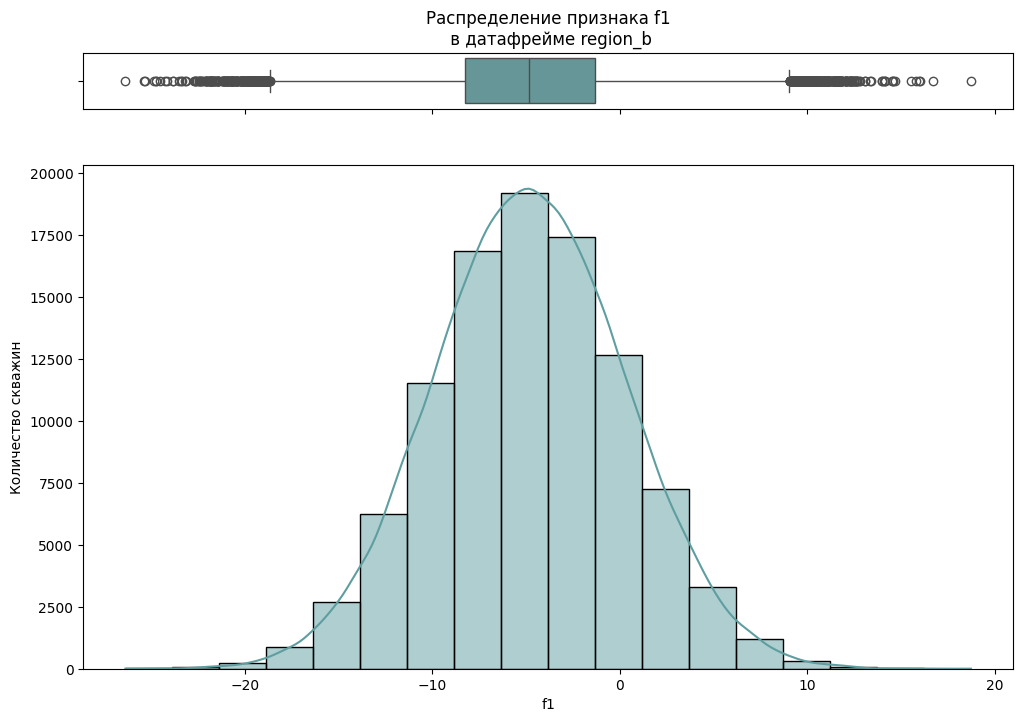

In [29]:
#признак f1 датафрейма region_b
quant_feat_analysis(region_b, 'f1', 'region_b')

Базовые статистики

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64
-----------------------------------------------------


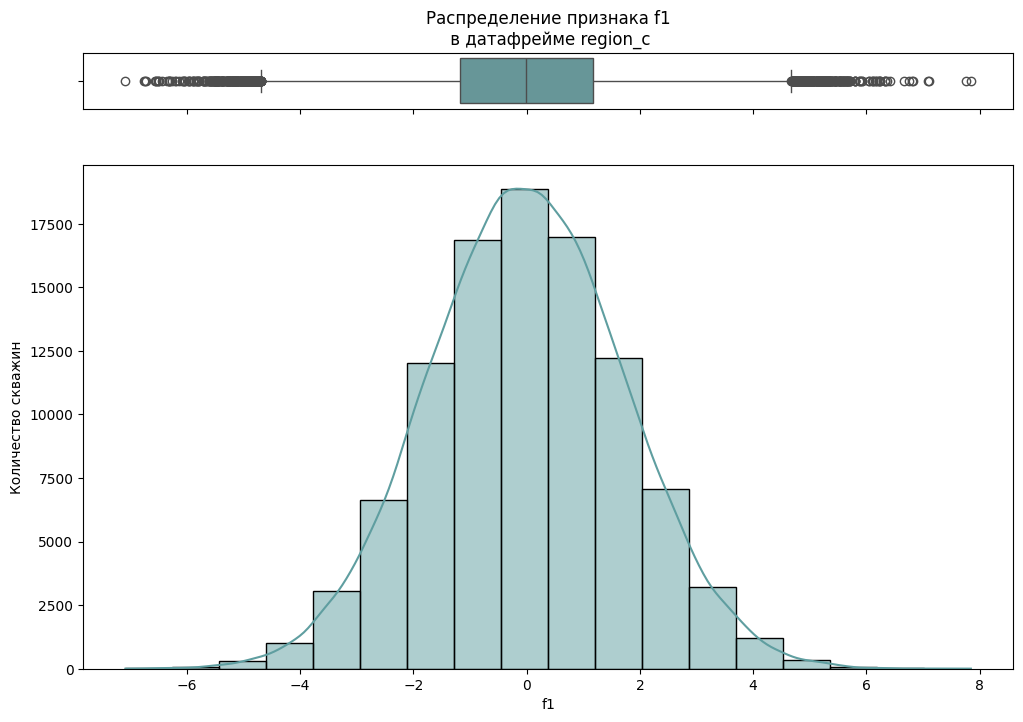

In [30]:
#признак f1 датафрейма region_c
quant_feat_analysis(region_c, 'f1', 'region_c')

Распределения признака `f1` в трёх датафреймах также имеют различную структуру. Для датафрейма `region_a` наблюдаем полимодальное распределение признака (можно выделить три моды), для датафреймов `region_b` и `region_c` - мономодальные распределения, имеющие структуру нормального. 

При этом стоит отметить, что для всех датафреймов область значений признака значительно различается - размах признака для датафрейма `region_a` примерно в 20 раз меньше в сравнении с датафреймом `region_b` и примерно в 7 раз меньше в сравнении с датафреймом `region_c`. При этом явных выбросов и аномальных значений не наблюдается ни в одном из датафреймов - отмеченные боксплотами выбросы в датафреймах `region_b` и `region_c` удалять не будем ввиду не очень сильного отклонения от "усов" боксплотов.

Для каждого из трёх датафреймов не наблюдается смещения признака в какую-либо область - медианы и средние имеют достаточно близкие значения. При этом данные статистики для датафрейма `region_b` значительно смещены в область более отрицательных значений относительно двух других датафреймов

### f2

Базовые статистики

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64
-----------------------------------------------------


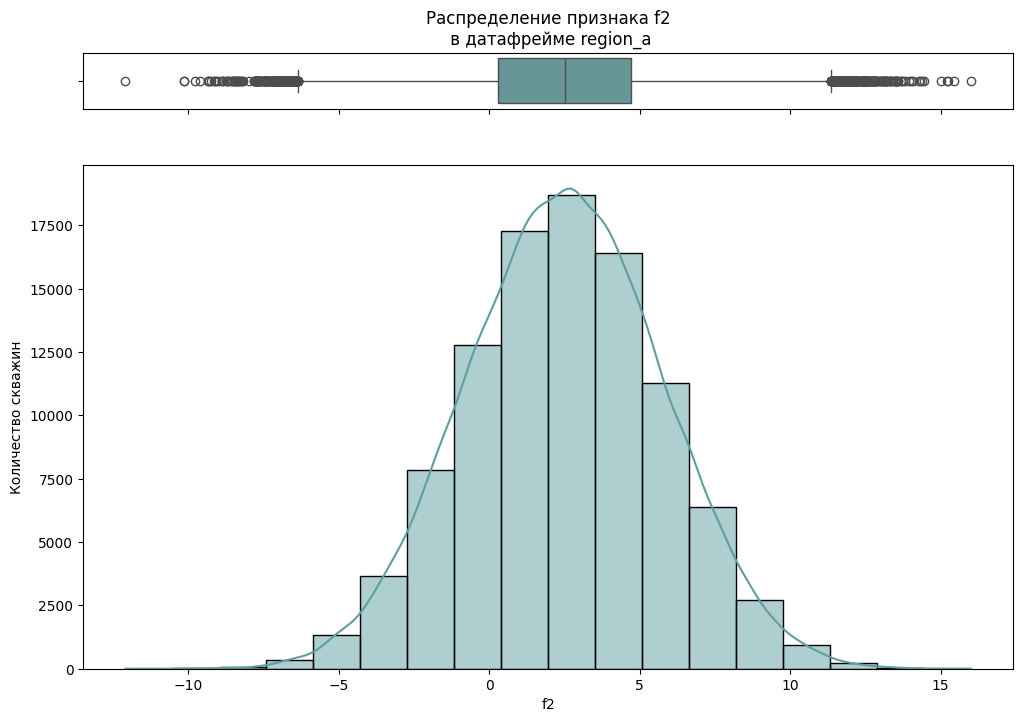

In [31]:
#признак f2 датафрейма region_a
quant_feat_analysis(region_a, 'f2', 'region_a')

Базовые статистики

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64
-----------------------------------------------------


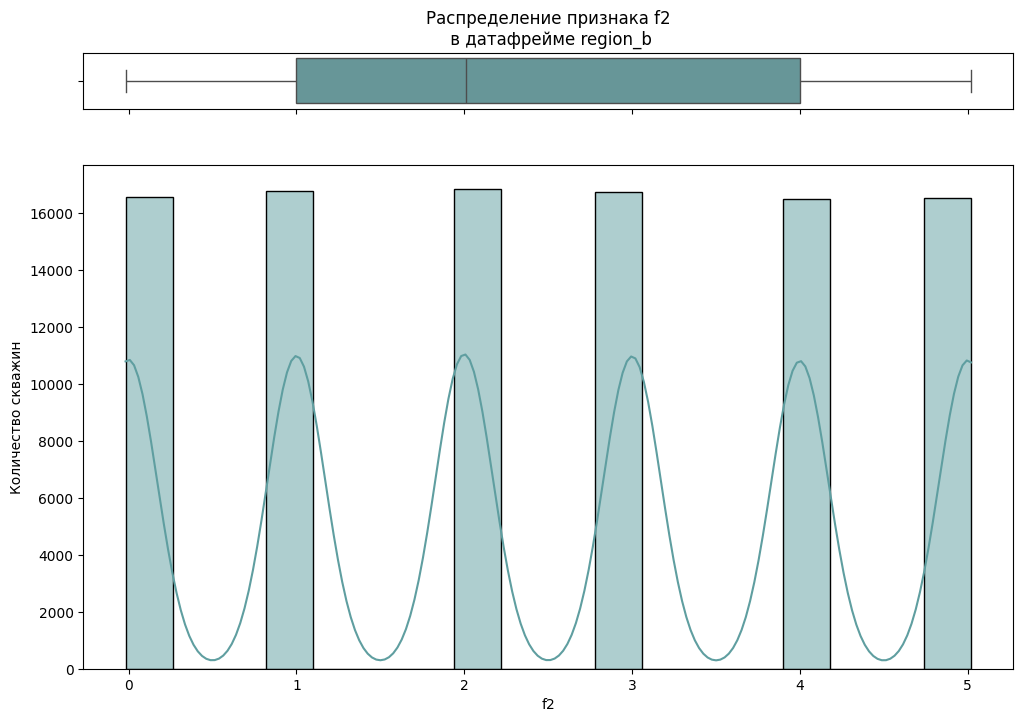

In [32]:
#признак f2 датафрейма region_b
quant_feat_analysis(region_b, 'f2', 'region_b')

Базовые статистики

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64
-----------------------------------------------------


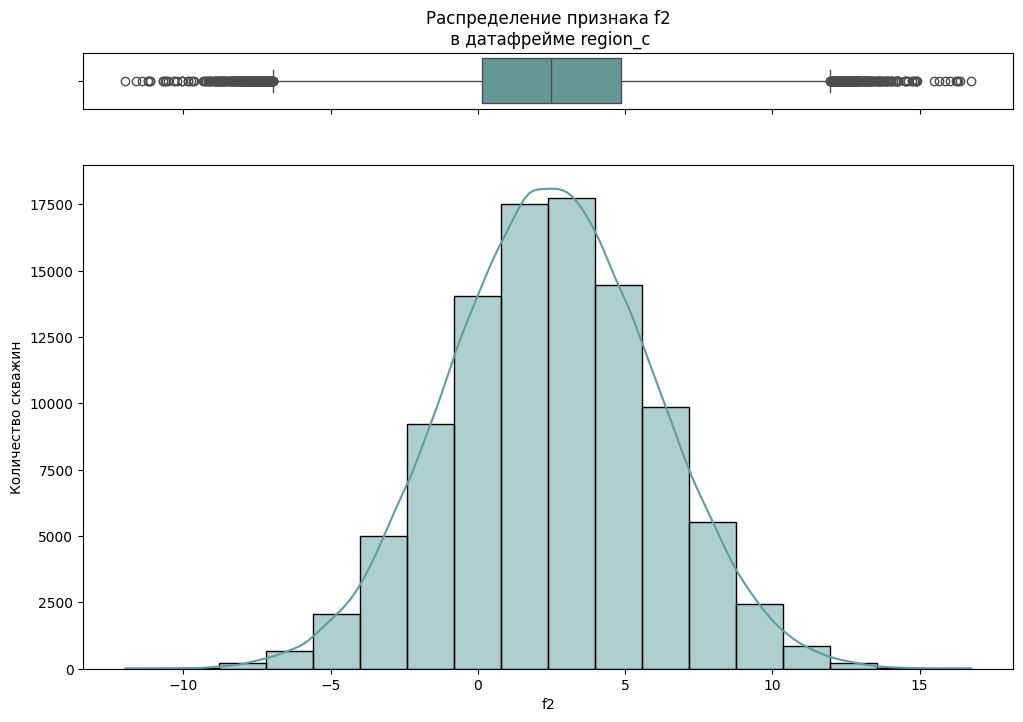

In [33]:
#признак f2 датафрейма region_c
quant_feat_analysis(region_c, 'f2', 'region_c')

Распределения признака `f2` в трёх датафреймах также имеют различную структуру. Для датафреймов `region_a` и `region_c` наблюдаем мономодальные распределения, имеющие структуру нормального, а в датафрейме `region_b` распределение признака напоминает равномерное с шестью категориями, где значения признака сгруппированы в примерно равных пропорциях вблизи целых чисел от 0 до 5 включительно.

При этом стоит отметить, что основные статистики признака в датафреймах `region_a` и `region_c` имеют схожие значения - квартили, средние, минимальные и максимальные значения. При этом явных выбросов и аномальных значений не наблюдается ни в одном из датафреймов - отмеченные боксплотами выбросы в датафреймах `region_a` и `region_c` удалять не будем ввиду не очень сильного отклонения от "усов" боксплотов.

Для датафреймов `region_a` и `region_c` не наблюдается смещения значений признака в какую-либо область - медианы и средние имеют достаточно близкие значения. Для датафрейма `region_b`, как уже было сказано выше, визуально можно отметить 6 примерно равномерно распределённых групп признаков вблизи целых чисел от 0 до 5 включительно.


На основании признака `f2` датафрейма `region_b` создадим категориальный признак `f2_cat` при помощи функции `f2_cat`

In [34]:
#функция перевода количественного признака f2
#в категориальный f2_cat
def f2_cat(row):
    #row - строка датафрейма
    
    f2 = row['f2']
    if f2 <= 0.5:
        return 0
    elif f2 <= 1.5:
        return 1
    elif f2 <= 2.5:
        return 2
    elif f2 <= 3.5:
        return 3
    elif f2 <= 4.5:
        return 4
    else:
        return 5
    
region_b['f2_cat'] = region_b.apply(f2_cat, axis=1)
region_b.head(20)    

,id,f0,f1,f2,product_mbbls,f2_cat
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,0
1,62mP7,14.272088,-3.475083,0.999183,26.953261,1
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,5
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,5
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,5
5,HHckp,-3.327590,-2.205276,3.003647,84.038886,3
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147,4
7,muH9x,4.234715,-0.001354,2.004588,53.906522,2
8,YiRkx,13.355129,-0.332068,4.998647,134.766305,5
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408,5


Уникальные значения

2    0.16862
1    0.16774
3    0.16751
0    0.16572
5    0.16537
4    0.16504
Name: f2_cat, dtype: float64
-----------------------------------------------------
Базовые статистики

count    100000.000000
mean          2.494520
std           1.703555
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: f2_cat, dtype: float64
-----------------------------------------------------


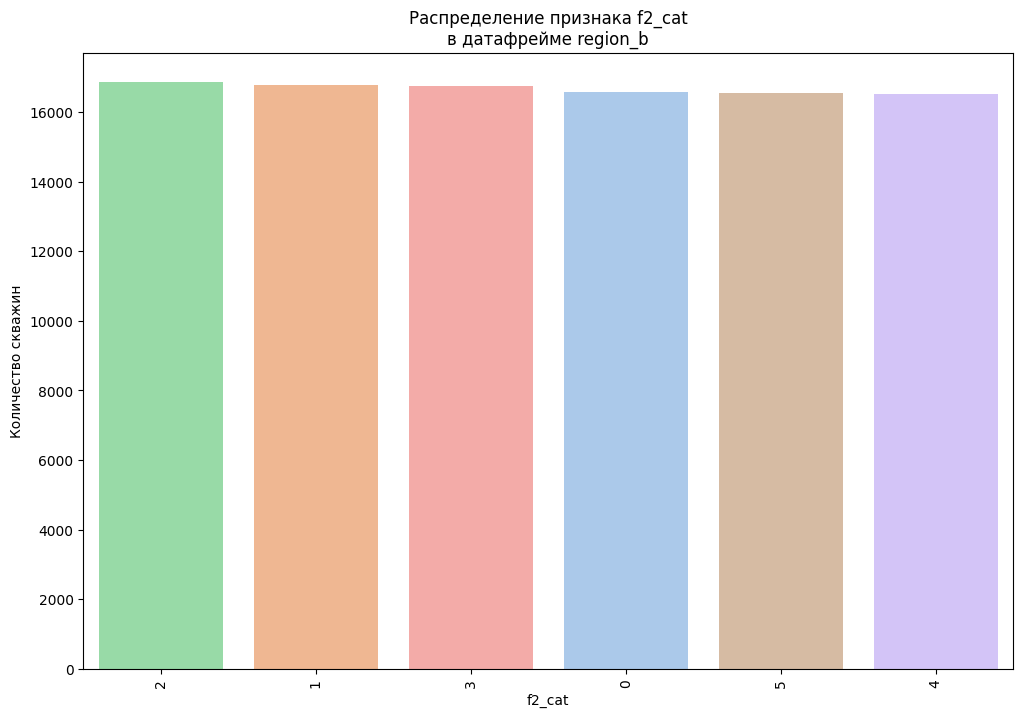

In [35]:
cat_feat_analysis(region_b, 'f2_cat', 'region_b')

Добавление категориального признака `f2_cat` в датафрейм `region_b` произведено успешно. Исходя из базовых статистик и столбчатой диаграммы видно, что признак распределён практически равномерно среди 6 категорий, разброс частот находится в пределах от 0.165 до 0.169


### product_mbbls

Базовые статистики

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product_mbbls, dtype: float64
-----------------------------------------------------


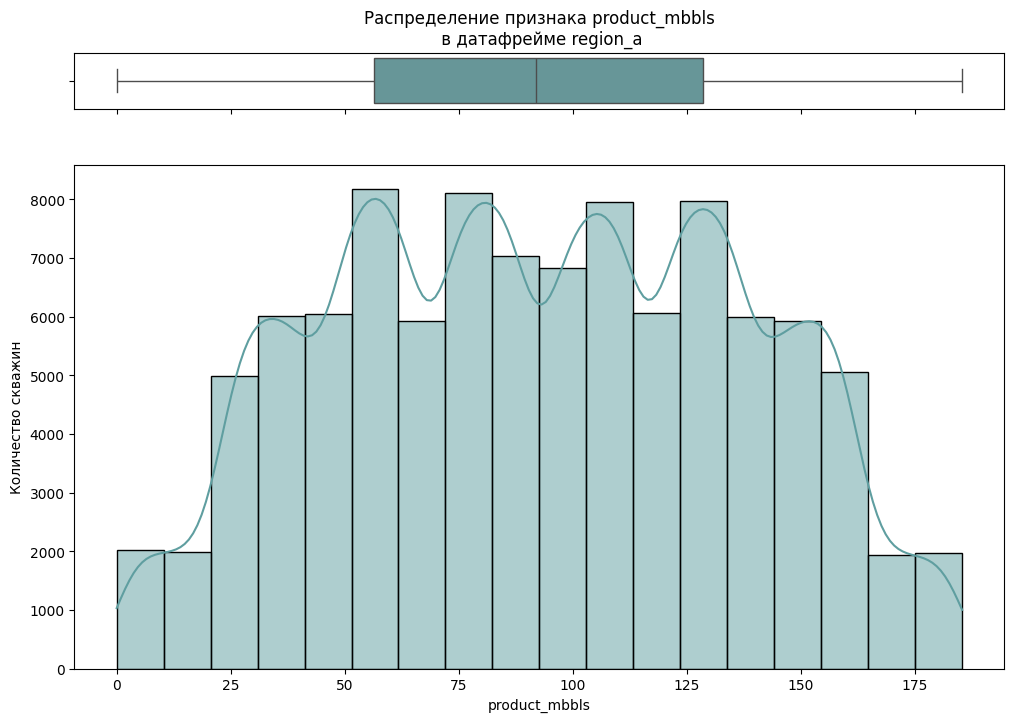

In [36]:
#таргет product_mbbls датафрейма region_a
quant_feat_analysis(region_a, 'product_mbbls', 'region_a')

Уникальные значения

53.906522     0.08472
26.953261     0.08468
84.038886     0.08431
57.085625     0.08390
3.179103      0.08337
80.859783     0.08320
30.132364     0.08306
134.766305    0.08304
110.992147    0.08303
0.000000      0.08235
137.945408    0.08233
107.813044    0.08201
Name: product_mbbls, dtype: float64
-----------------------------------------------------
Базовые статистики

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product_mbbls, dtype: float64
-----------------------------------------------------


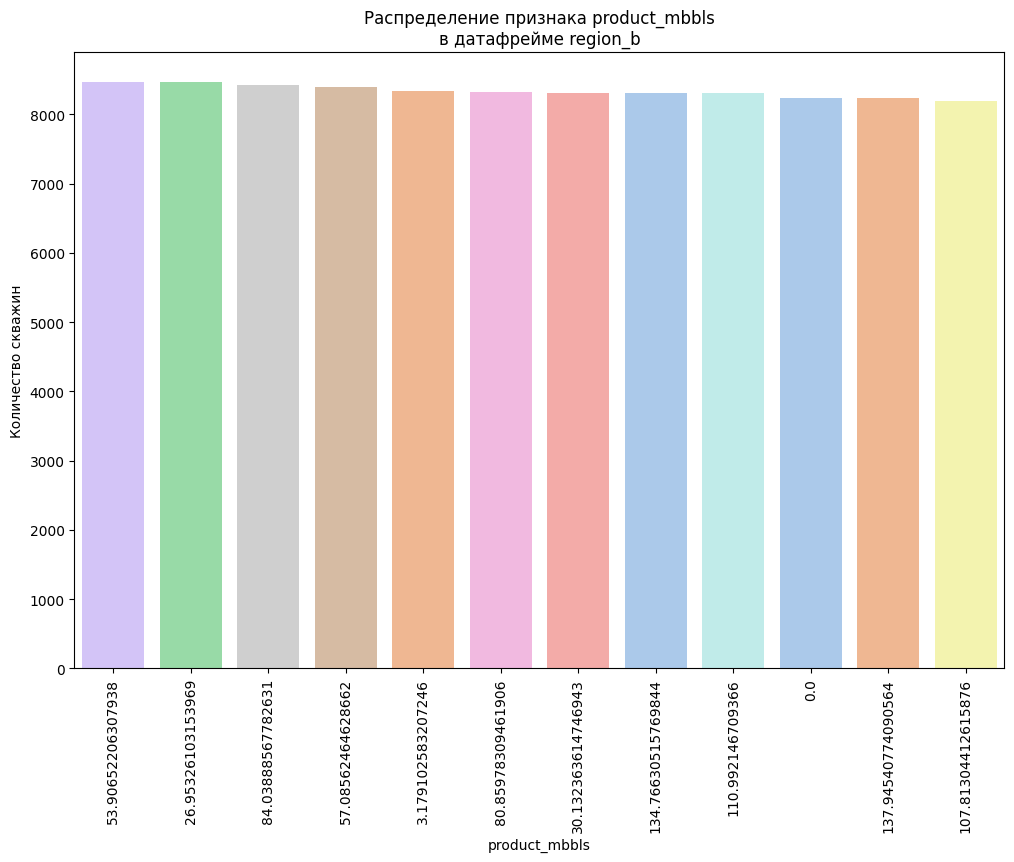

In [37]:
#таргет product_mbbls датафрейма region_b
cat_feat_analysis(region_b, 'product_mbbls', 'region_b')

Базовые статистики

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product_mbbls, dtype: float64
-----------------------------------------------------


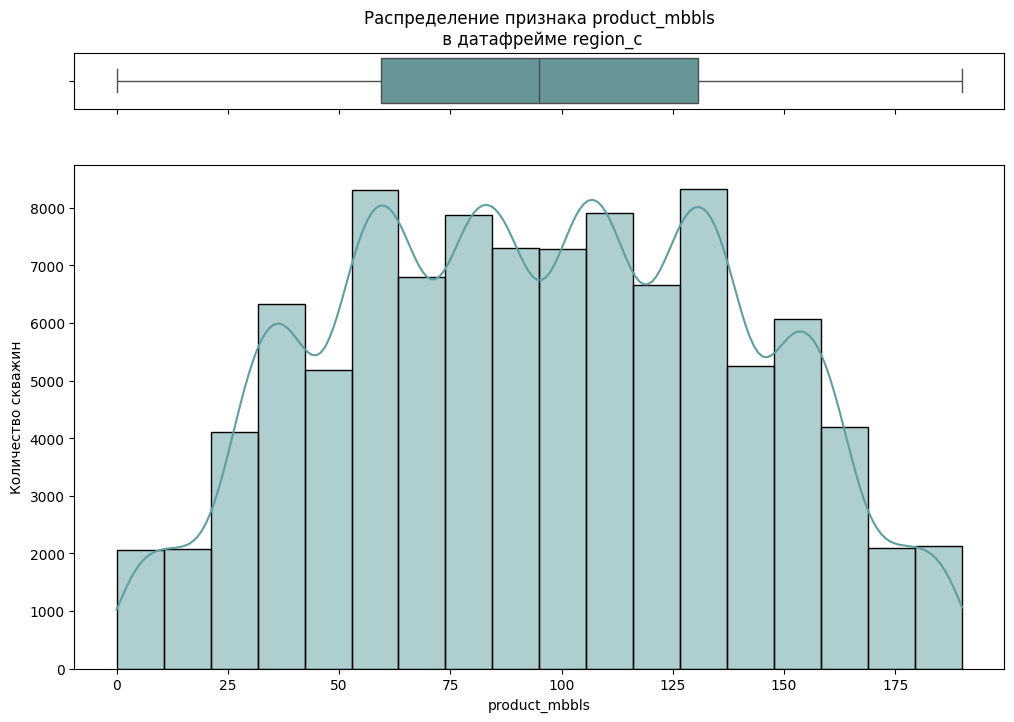

In [38]:
#таргет product_mbbls датафрейма region_c
quant_feat_analysis(region_c, 'product_mbbls', 'region_c')

Распределения таргета `product_mbbls` в трёх датафреймах также имеют различную структуру. Для датафреймов `region_a` и `region_c` наблюдаем распределения, имеющие промежуточную между нормальным и равномерным структуру, а в датафрейме `region_b` распределение признака практически равномерное с 12 категориями.

При этом стоит отметить, что основные статистики таргета в датафреймах `region_a` и `region_c` имеют достаточно близкие значения - квартили, средние, минимальные и максимальные значения близки с небольшим смещением в сторону бОльших значений для датафрейма `region_c`. При этом явных выбросов и аномальных значений не наблюдается ни в одном из двух датафреймов.

Для датафреймов `region_a` и `region_c` не наблюдается смещения значений признака в какую-либо область - медианы и средние имеют достаточно близкие значения. Для датафрейма `region_b`, как уже было сказано выше,  можно отметить 12 достаточно равномерно распределённых категорий признака, разброс частот составляет от 0.082 до 0.085.

Посмотрим на долю скважин, имеющих нулевые запасы нефти, для датафреймов `region_a` и `region_c`

In [39]:
#region_a
region_a.query('product_mbbls == 0').head()

,id,f0,f1,f2,product_mbbls
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


In [40]:
#region_c
region_c.query('product_mbbls == 0').head()

,id,f0,f1,f2,product_mbbls
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Имеем, что в регионах A и С располагается всего лишь по одной (0.001% от общего числа) скважине с нулевым запасом нефти, тогда как в регионе B таких скважин более 8 процентов. Без детального погружения в специфику задачи и особенности скважин трудно сказать, с чем может быть связаны данные аномалии, также как и особое распределение таргета для всего региона B. Точно можно сказать, что скважины с нулевыми запасами нефти нас не будут интересовать

Таким образом, в данном разделе был проведён исследовательский анализ данных в трёх имеющихся датафреймах:

* было установлено, что одинаковые признаки имеют различные распределения и статистики для разных датафреймов;
* установлено, что в данных отсутствуют аномальные значения; выбросы, отмеченные боксплотами, было решено не удалять;
* на основании количественного признака `f2` датафрейма `region_b` был создан категориальный признак `f2_cat`, поскольку значения исходного признака были практически равномерно распределены вокруг целых чисел от 0 до 5 включительно;
* распределения таргета в датафреймах `region_a` и `region_c` похожи и имеют промежуточную между нормальным и равномерным структуру. При этом таргет в датафрейме `region_b` распределён практически равномерно между 12 категориями, одна из которых - скважины с нулевым запасом нефти (более 8 процентов от общего числа), тогда как в других датафреймах таких записей - 0.001%;
* с учётом того, что признаки имеют разный масштаб, необходимо будет провести дополнительную предобработку количественных признаков с помощью `StandardScaler`

## Корреляционный анализ

В условии задачи сказано, что все признаки точек значимые. Однако для понимания данных и анализа корреляций между таргетом и признаками всё равно проведём корреляционный анализ. Сначала посмотрим на матрицы парных корреляций Спирмена для всех трёх датафреймов

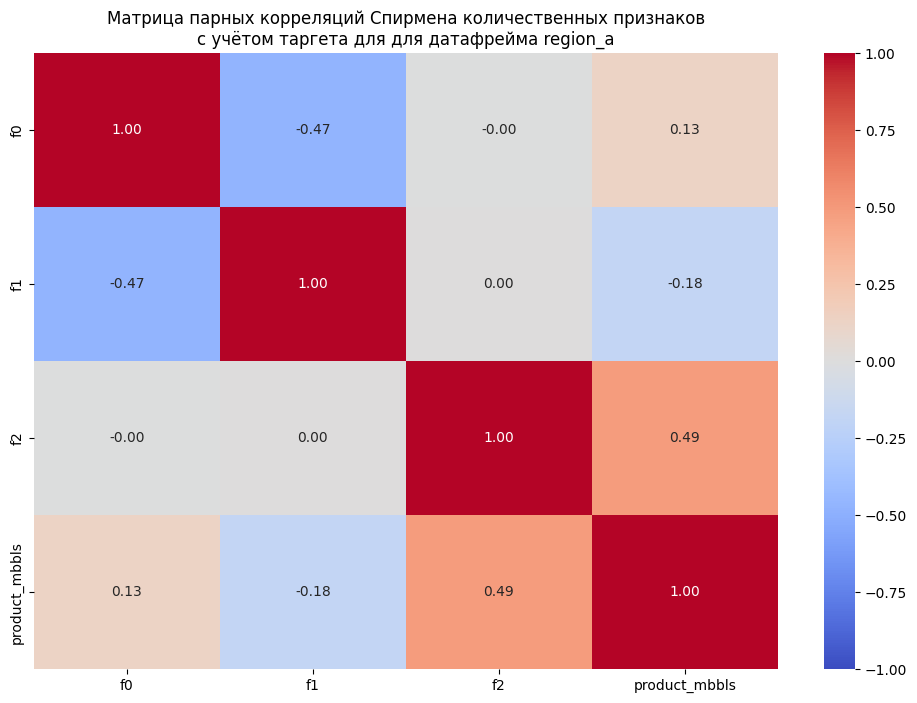

In [41]:
#рассчитаем коэффициенты корреляции Спирмена между количественными признаками с учётом таргета
#для датафрейма region_a
spearman_region_a = region_a.corr(method='spearman')
sns.heatmap(spearman_region_a,
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций Спирмена количественных признаков\n'
                                 'с учётом таргета для для датафрейма region_a');

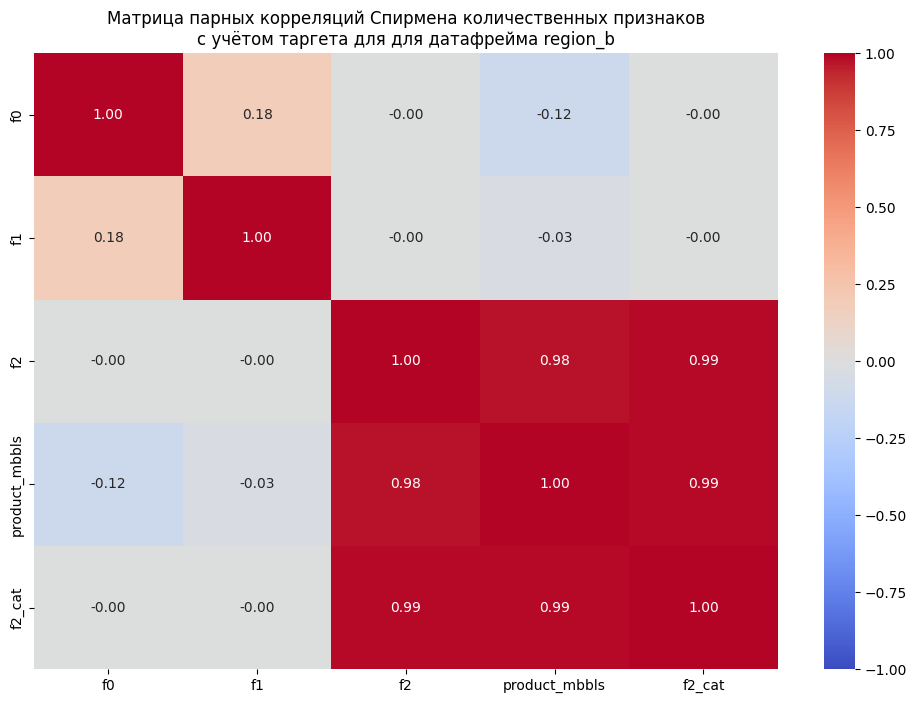

In [42]:
#рассчитаем коэффициенты корреляции Спирмена между количественными признаками с учётом таргета
#для датафрейма region_b
spearman_region_b = region_b.corr(method='spearman')
sns.heatmap(spearman_region_b,
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций Спирмена количественных признаков\n'
                                 'с учётом таргета для для датафрейма region_b');

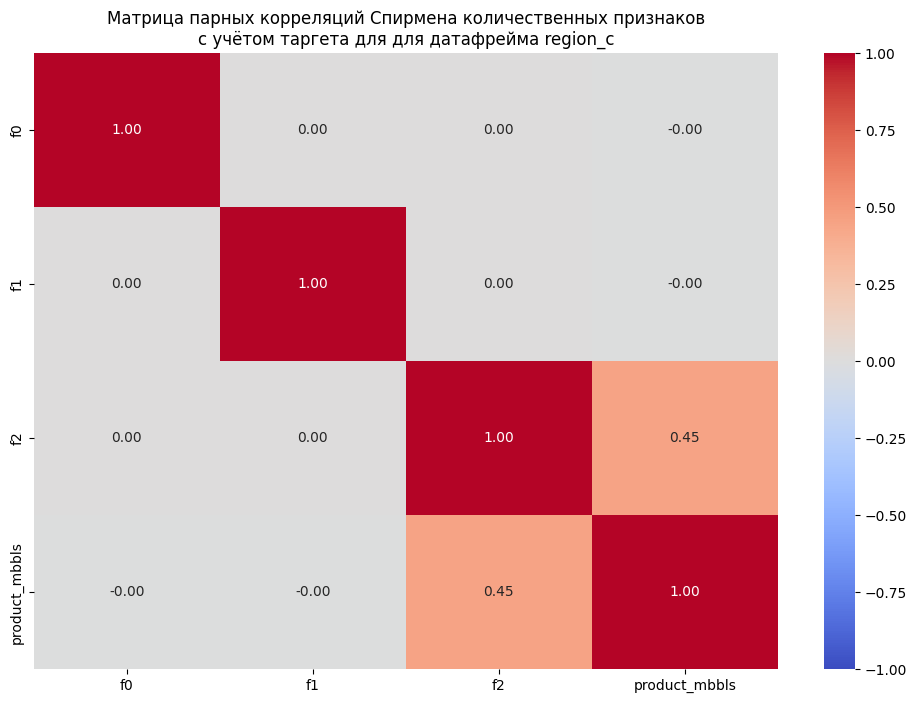

In [43]:
#рассчитаем коэффициенты корреляции Спирмена между количественными признаками с учётом таргета
#для датафрейма region_c
spearman_region_c = region_c.corr(method='spearman')
sns.heatmap(spearman_region_c,
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций Спирмена количественных признаков\n'
                                 'с учётом таргета для для датафрейма region_c');

Для трёх датафреймов получили разные паттерны взаимосвязей:
* `region_c`: единственную ненулевую корреляцию с таргетом показывает признак `f2` (0.45, умеренная положительная);
* `region_a`: помимо умеренной корреляции признака `f2` с таргетом, слабые корреляции с целевым признаком также имеют признаки `f0` и `f1`; также отметим умеренную отрицательную корреляцию между признаками `f0` и `f1`;
* `region_b`: признаки `f2` и `f2_cat` имеют очень сильную положительную корреляцию с таргетом, коэффициент корреляции практически равен 1

Теперь проведём анализ с помощью библиотеки `phik`

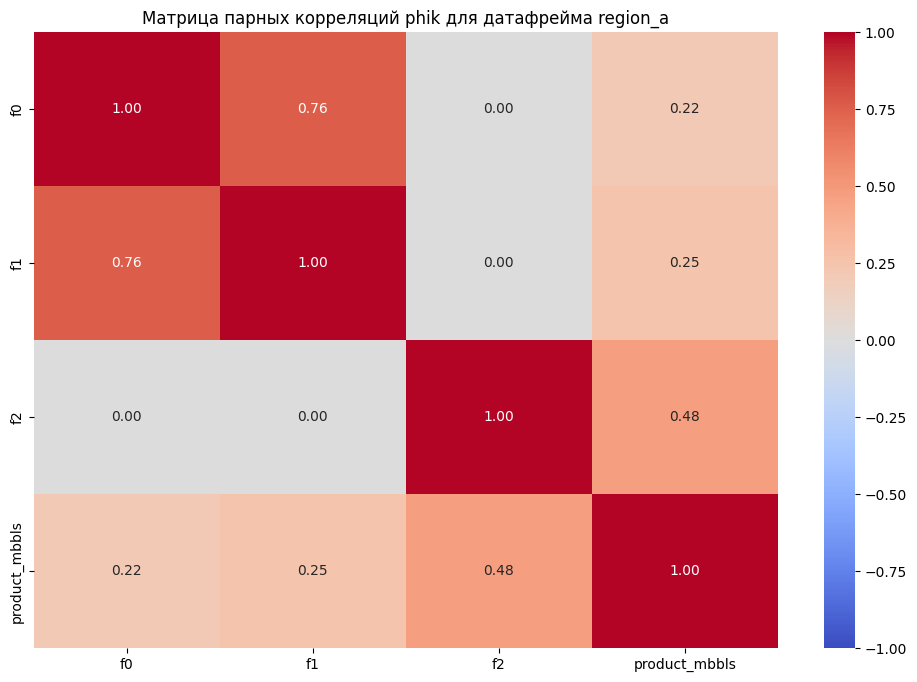

In [44]:
#создадим датафрейм phik_region_a, 
#в который войдут все признаки датафрейма region_a, кроме id
phik_region_a = region_a.loc[:, region_a.columns != 'id']

#рассчитаем коэффициенты корреляции между всеми признаками для датафрейма region_a
sns.heatmap(phik_region_a.phik_matrix(interval_cols=['f0',
                                                     'f1',
                                                     'f2',
                                                     'product_mbbls']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для датафрейма region_a');

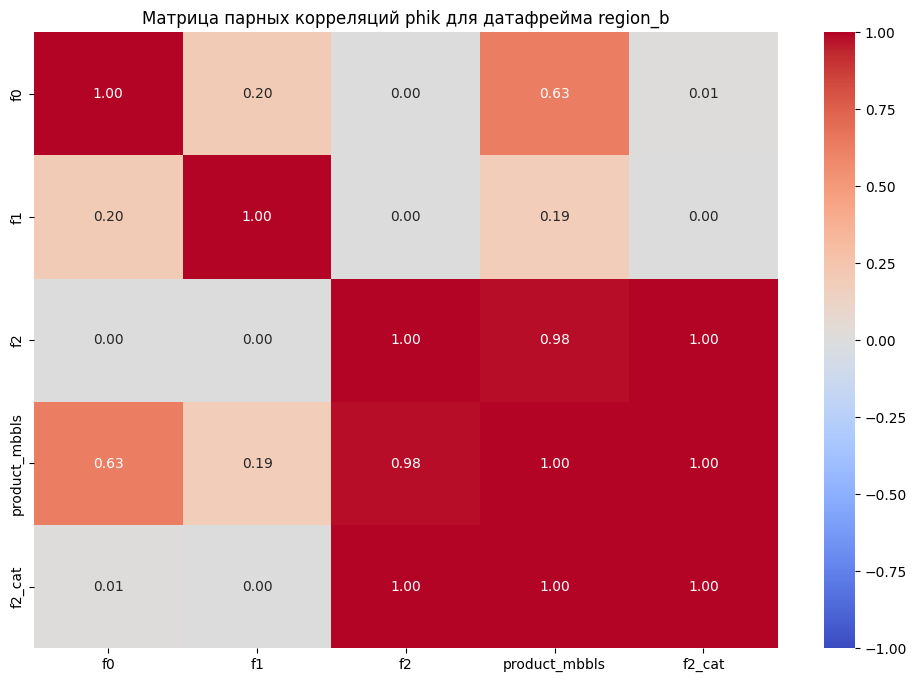

In [45]:
#создадим датафрейм phik_region_b, 
#в который войдут все признаки датафрейма region_b, кроме id
phik_region_b = region_b.loc[:, region_b.columns != 'id']

#рассчитаем коэффициенты корреляции между всеми признаками для датафрейма region_b
sns.heatmap(phik_region_b.phik_matrix(interval_cols=['f0',
                                                     'f1',
                                                     'f2',
                                                     'f2_cat',
                                                     'product_mbbls']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для датафрейма region_b');

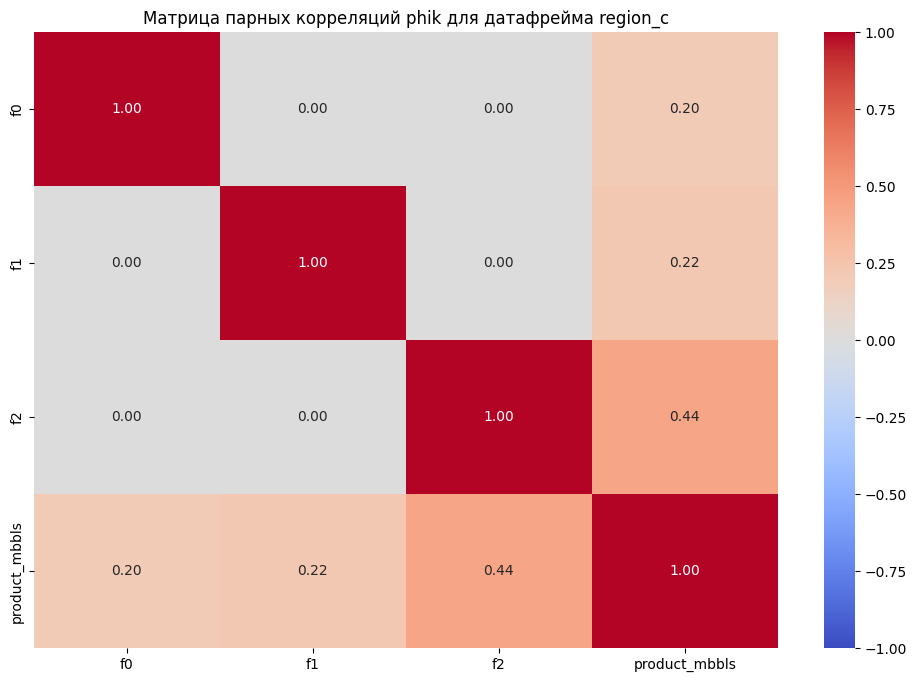

In [46]:
#создадим датафрейм phik_region_c, 
#в который войдут все признаки датафрейма region_c, кроме id
phik_region_c = region_c.loc[:, region_c.columns != 'id']

#рассчитаем коэффициенты корреляции между всеми признаками для датафрейма region_c
sns.heatmap(phik_region_c.phik_matrix(interval_cols=['f0',
                                                     'f1',
                                                     'f2',
                                                     'product_mbbls']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для датафрейма region_c');

Все те основные закономерности, которые наблюдались ранее для корреляций Спирмена, наблюдаем и для корреляций phik. Отметим наиболее значимые новые сведения:
* `region_a`: более заметная корреляция между признаками `f0` и `f1`;
* `region_b`: заметная корреляция между таргетом и `f0`;

Кроме того, посмотрим для каждого датафрейма, какие признаки имеют наибольшую корреляцию между собой для наиболее богатых нефтью скважин. Для `region_a` возьмём 25% самых богатых нефтью скважин со значением таргета не менее 128.5

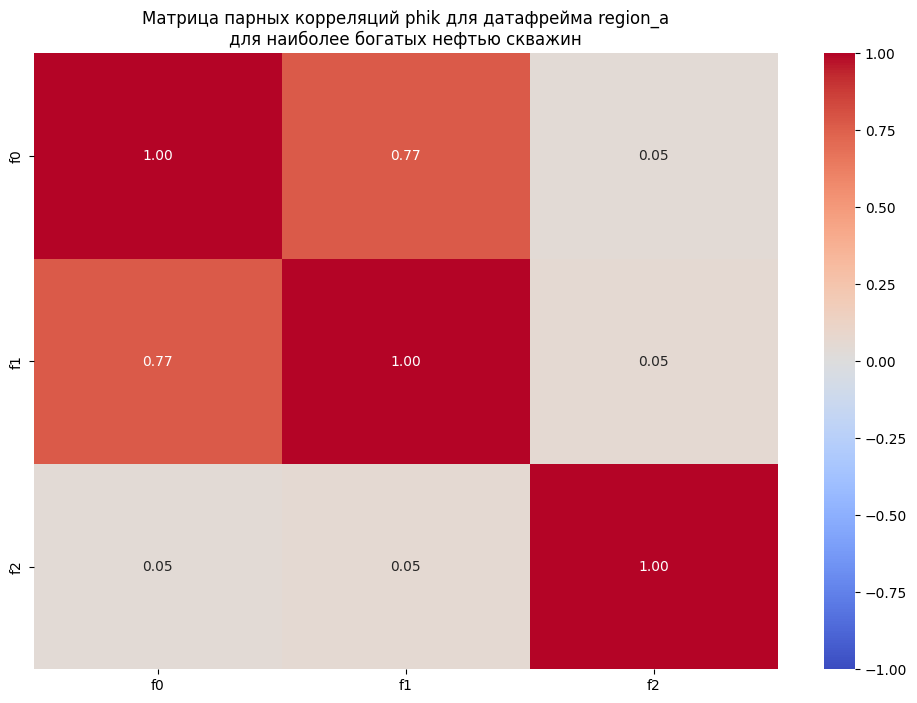

In [47]:
#рассчитаем коэффициенты корреляции между признаками для датафрейма region_a
#для наиболее богатых нефтью скважин
sns.heatmap(phik_region_a.query('product_mbbls > 128.5')
                         .loc[:, phik_region_a.columns != 'product_mbbls']  
                         .phik_matrix(interval_cols=['f0',
                                                     'f1',
                                                     'f2']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для датафрейма region_a\n'
                                 'для наиболее богатых нефтью скважин');

Значимых изменений по сравнению с предыдущими матрицами корреляций не наблюдается

Для `region_b` возьмём 25% самых богатых нефтью скважин со значением таргета не менее 107

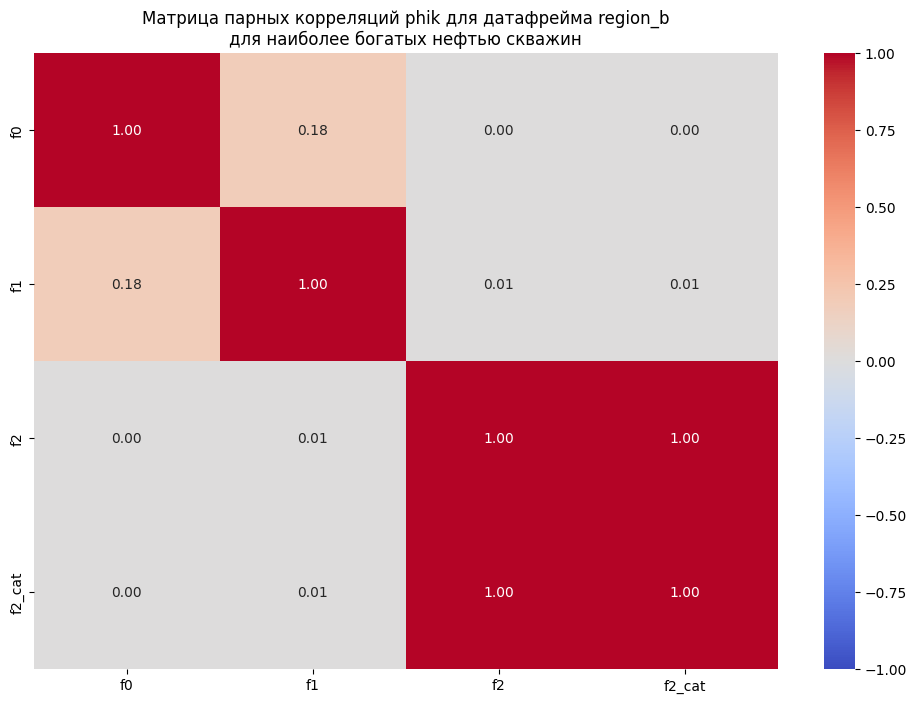

In [48]:
#рассчитаем коэффициенты корреляции между признаками для датафрейма region_b
#для наиболее богатых нефтью скважин
sns.heatmap(phik_region_b.query('product_mbbls > 107')
                         .loc[:, phik_region_b.columns != 'product_mbbls']  
                         .phik_matrix(interval_cols=['f0',
                                                     'f1',
                                                     'f2',
                                                     'f2_cat']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для датафрейма region_b\n'
                                 'для наиболее богатых нефтью скважин');

Значимых изменений не наблюдается

Для `region_c` возьмём 25% самых богатых нефтью скважин со значением таргета не менее 130.5

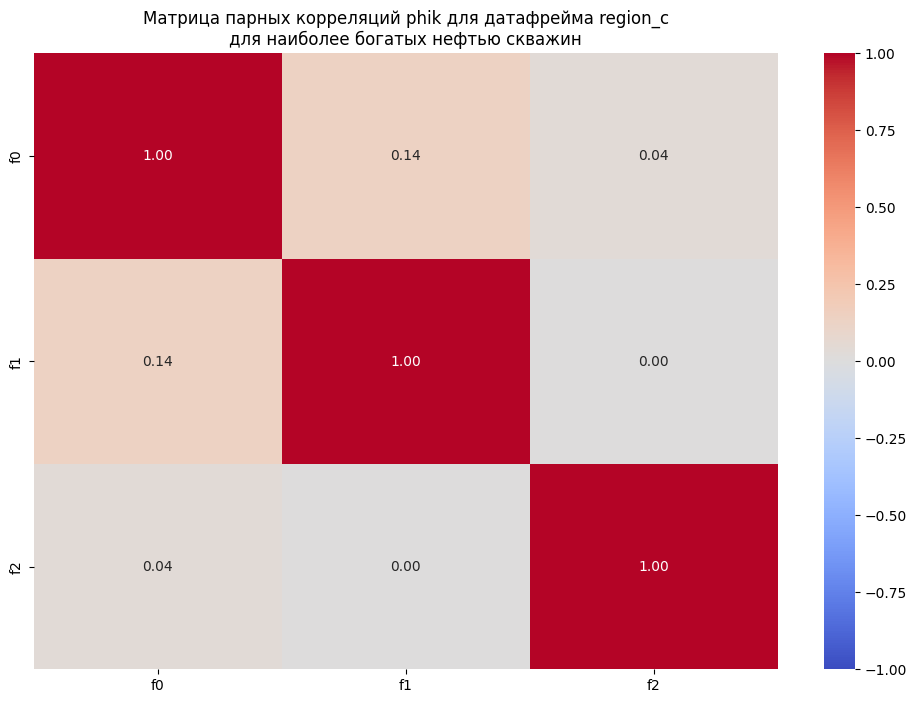

In [49]:
#рассчитаем коэффициенты корреляции между признаками для датафрейма region_c
#для наиболее богатых нефтью скважин
sns.heatmap(phik_region_c.query('product_mbbls > 130.5')
                         .loc[:, phik_region_c.columns != 'product_mbbls']  
                         .phik_matrix(interval_cols=['f0',
                                                     'f1',
                                                     'f2']),
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            fmt='.2f').set(title='Матрица парных корреляций phik для датафрейма region_c\n'
                                 'для наиболее богатых нефтью скважин');

Значимых изменений не наблюдается

Наконец, рассмотрим диаграмму рассеяния в датафрейме `region_b` между признаками `f2` и таргетом, коэффициент корреляции phik между которыми почти равен 1

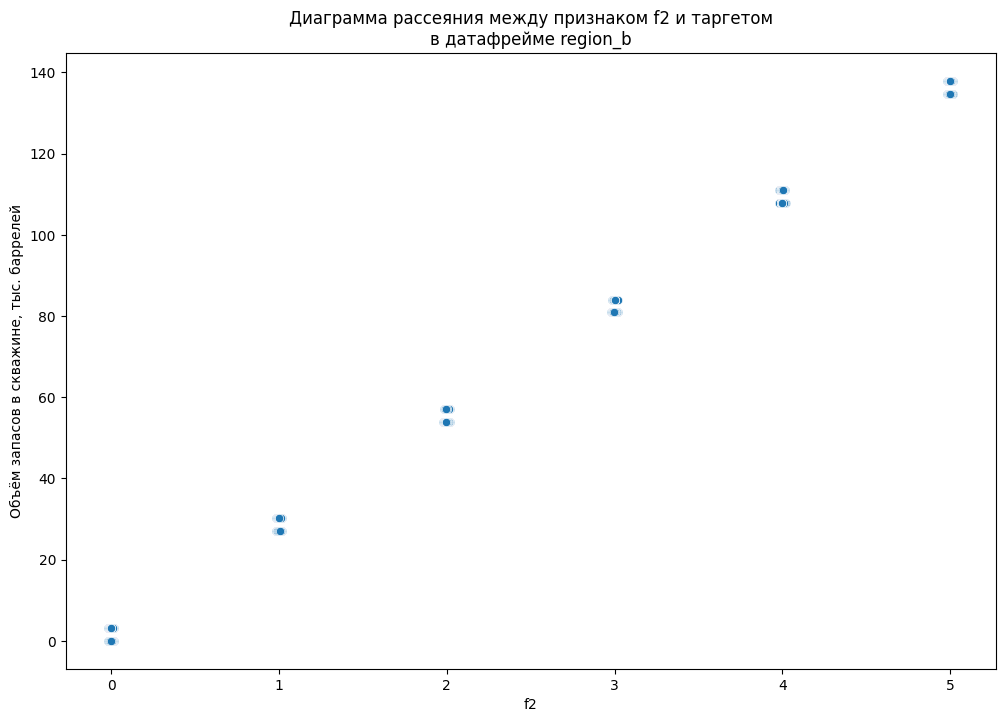

In [50]:
sns.scatterplot(data=region_b,
                x='f2',
                y='product_mbbls',
                legend='auto').set(title='Диаграмма рассеяния между признаком f2 и таргетом\n'
                                            'в датафрейме region_b', 
                                   xlabel='f2',
                                   ylabel='Объём запасов в скважине, тыс. баррелей');

Явно видно, что значения таргета однозначно описываются признаками `f2` и, что логично, `f2_cat` - между этими признаками и таргетом очень точная линейная зависимость. С учётом того, что и исходный, и синтетический категориальный признаки практически достоверно предсказывают значения таргета, для обучения моделей лучше было бы оставить категориальный признак `f2_cat` ввиду того, что он потенциально лучше сможет обрабатывать ситуации, когда в будущем значение признака гипотетичски может отличаться от текущих значений признака. Однако для единообразия обучения моделей на всех трёх датасетах на одинаковых признаках возьмём исходный признак `f2` 

Таким образом, в данном разделе был проведён корреляционный анализ имеющихся датафреймов:
* для всех трёх датафреймов признаком, имеющим наибольшую корреляцию с таргетом, оказался признак `f2`;
* при этом в датафрейме `region_b` корреляция признаков `f2` и синтезированного на его основе категориального `f2_cat` с таргетом близка к единице. Для обучения моделей было решено оставить исходный признак `f2`, чтобы все модели обучались на признаках одинакового типа, а также с учётом того, что в условии сказано о значимости всех исходных признаков;
* мультиколлинеарности между исходными признаками не наблюдается (за исключением `f2` и `f2_cat` по понятным причинам);
* также можно отметить достаточно высокие корреляции phik между признаками `f0` и `f1` для датафрейма `region_a`, а также `f0` и таргета для датафрейма `region_b`;
* с учётом того, что предлагается решать поставленную задачу с помощью линейной регрессии, можно предположить, что с высокой вероятностью наиболее качественной окажется модель, обученная на датафрейме `region_b` ввиду практически однозначной линейной зависимости таргета от признака `f2`

## Обучение моделей

In [51]:
#создадим собственную функцию для расчёта rmse
def manual_rmse(y_true, y_pred):
    
    #y_true - массив фактических значений таргета
    #y_pred - массив предсказанных значений таргета
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

rmse_score = make_scorer(
    manual_rmse,
    greater_is_better=False
)

Для каждого из трёх регионов:
* выделим тренировочные и валидационные данные;
* обучим модель и сделаем предсказания на валидационной выборке;
* выведем на экран значения метрик на тренировочных и валидационных данных, лучшую модель,
средний запас предсказанного сырья;
* сохраним характеристики из предыдущего пункта, а также истинные и предсказанные значения таргета


### region_a

Подготовим данные для обучения. 

In [52]:
#зададим необходимые константы
random_state = 42
train_size = 0.75

#выделим необходимое признаковое описание
X_a = region_a.drop(['id',
                     'product_mbbls'], axis=1)

y_a = region_a['product_mbbls']

X_train_a, X_valid_a, y_train_a, y_valid_a = train_test_split(
    X_a,
    y_a,
    random_state=random_state,
    train_size=train_size)

#проверим корректность разбиения на выборки
X_train_a.shape, X_valid_a.shape, y_train_a.shape, y_valid_a.shape

((75000, 3), (25000, 3), (75000,), (25000,))

Разбиение на выборки произведено успешно. Подготовим список признаков

In [53]:
num_cols = ['f0',
            'f1',
            'f2']

#создадим списки с названиями датафреймов, метрикой лучшей модели на тренировочных данных,
#метрикой лучшей модели на валидационных данных и средним запасом предсказанного сырья
regions_list = []
train_rmse = []
valid_rmse = []
oil_reserve_mean = []

Создадим пайплайн. 

В качестве метрики в задаче предложена `RMSE`. Исходные данные были разделены на признаковое описание и целевую переменную, а затем - на тренировочные и валидационные в соотношении 3:1.

Для количественных признаков `num_cols` используем маcштабирование с помощью `StandardScaler`.

Ввиду условия задачи - использование только линейной регрессии - будем исследовать линейную модель `ElasticNet` и проварьируем гиперпараметры `alpha` и `l1_ratio` для подбора оптимальных коэффициетов регуляризации, улучшения обобщающей способности модели и снижения переобучения.

Оптимизацию гиперпараметров будем проводить с помощью `OptunaSearchCV`. Качество моделей определим по метрике `RMSE` на тренировочных данных. Лучшая модель затем будет использоваться для получения прогнозных значений на валидационной выборке.

In [54]:
#создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_cols)]
)

#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', ElasticNet(random_state=random_state))
    ]
)

#создадим сетку гиперпараметров
param_grid = {

    #распределение гиперпараметров для модели ElasticNet()
    'models__alpha' : distributions.FloatDistribution(1e-5, 1e3, log=True),
    'models__l1_ratio' : distributions.FloatDistribution(1e-10, 1.0, log=True)
        
}

Объявим перебор гиперпараметров для региона `region_a`

In [55]:
#объявляем класс OptunaSearchCV
oscv_enet_a = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring=rmse_score,
    cv=5,
    n_trials=50,
    random_state=random_state
)

#объявляем перебор гиперпараметров
oscv_enet_a.fit(X_train_a, y_train_a)

#проверяем работу модели на тренировочной выборке
regions_list.append('a')
train_rmse.append(abs(oscv_enet_a.best_score_))
print('Лучшая модель для региона A:\n\n', oscv_enet_a.best_estimator_)
print('\nRMSE лучшей модели на тренировочных данных для региона A:', abs(oscv_enet_a.best_score_))


#проверим качество модели на валидационной выборке
y_pred_a = oscv_enet_a.predict(X_valid_a)
valid_rmse.append(manual_rmse(y_valid_a, y_pred_a))
print(f'RMSE лучшей модели на валидационной выборке для региона A: {manual_rmse(y_valid_a, y_pred_a)}')

#получим значение среднего запаса предсказанного сырья
oil_reserve_mean.append(y_pred_a.mean())
print(f'Средний запас предсказанного сырья в регионе A: {y_pred_a.mean()}')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17712\511780858.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_enet_a = optuna.integration.OptunaSearchCV(
[I 2025-09-13 03:17:13,666] A new study created in memory with name: no-name-23adb53d-330a-4c49-9883-49c70f1838dd
[I 2025-09-13 03:17:13,804] Trial 0 finished with value: -37.68319093892527 and parameters: {'models__alpha': 0.04341186239881871, 'models__l1_ratio': 0.021199241539924266}. Best is trial 0 with value: -37.68319093892527.
[I 2025-09-13 03:17:13,929] Trial 1 finished with value: -37.672005280317094 and parameters: {'models__alpha': 3.5678840078350484e-05, 'models__l1_ratio': 1.5648492655936056e-07}. Best is trial 1 with value: -37.672005280317094.
[I 2025-09-13 03:17:14,047] Trial 2 finished with value: -37.705747373425844 and parameters: {'models__alpha': 0.07611978339693477, 'models__l1_ratio': 9.607630975034648e-08}. Best is trial 1 with val

[I 2025-09-13 03:17:18,122] Trial 32 finished with value: -37.672005301883246 and parameters: {'models__alpha': 2.76158596602499e-05, 'models__l1_ratio': 0.08200696062230659}. Best is trial 30 with value: -37.672005121370326.
[I 2025-09-13 03:17:18,242] Trial 33 finished with value: -37.672005142666926 and parameters: {'models__alpha': 0.00013596336833884452, 'models__l1_ratio': 0.02598188762898597}. Best is trial 30 with value: -37.672005121370326.
[I 2025-09-13 03:17:18,364] Trial 34 finished with value: -37.67201024498647 and parameters: {'models__alpha': 0.0010827166664534984, 'models__l1_ratio': 0.022655821275532628}. Best is trial 30 with value: -37.672005121370326.
[I 2025-09-13 03:17:18,490] Trial 35 finished with value: -37.672005312852185 and parameters: {'models__alpha': 2.1098266742218337e-05, 'models__l1_ratio': 0.01654622952983637}. Best is trial 30 with value: -37.672005121370326.
[I 2025-09-13 03:17:18,619] Trial 36 finished with value: -37.67206187274942 and parameters

Лучшая модель для региона A:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models',
                 ElasticNet(alpha=0.0001882346685165508,
                            l1_ratio=0.0008082996115861673, random_state=42))])

RMSE лучшей модели на тренировочных данных для региона A: 37.67200512082583
RMSE лучшей модели на валидационной выборке для региона A: 37.75659584615687
Средний запас предсказанного сырья в регионе A: 92.39883111075798


### region_b

Подготовим данные для обучения

In [56]:
#выделим необходимое признаковое описание
X_b = region_b.drop(['id',
                     'f2_cat',
                     'product_mbbls'], axis=1)

y_b = region_b['product_mbbls']

X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(
    X_b,
    y_b,
    random_state=random_state,
    train_size=train_size)

#проверим корректность разбиения на выборки
X_train_b.shape, X_valid_b.shape, y_train_b.shape, y_valid_b.shape

((75000, 3), (25000, 3), (75000,), (25000,))

Разбиение на выборки произведено успешно. Объявим перебор гиперпараметров для региона `region_b`

In [57]:
#объявляем класс OptunaSearchCV
oscv_enet_b = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring=rmse_score,
    cv=5,
    n_trials=50,
    random_state=random_state
)

#объявляем перебор гиперпараметров
oscv_enet_b.fit(X_train_b, y_train_b)

#проверяем работу модели на тренировочной выборке
regions_list.append('b')
train_rmse.append(abs(oscv_enet_b.best_score_))
print('Лучшая модель и её параметры для региона B:\n\n', oscv_enet_b.best_estimator_)
print('\nRMSE лучшей модели на тренировочных данных для региона B:', abs(oscv_enet_b.best_score_))


#проверим качество модели на валидационной выборке
y_pred_b = oscv_enet_b.predict(X_valid_b)
valid_rmse.append(manual_rmse(y_valid_b, y_pred_b))
print(f'RMSE лучшей модели на валидационной выборке для региона B: {manual_rmse(y_valid_b, y_pred_b)}')

#получим значение среднего запаса предсказанного сырья
oil_reserve_mean.append(y_pred_b.mean())
print(f'Средний запас предсказанного сырья в регионе B: {y_pred_b.mean()}')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17712\1781373555.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_enet_b = optuna.integration.OptunaSearchCV(
[I 2025-09-13 03:17:20,363] A new study created in memory with name: no-name-d7771aa7-6c4d-477b-8cf1-519fb042e004
[I 2025-09-13 03:17:20,492] Trial 0 finished with value: -2.073938086557868 and parameters: {'models__alpha': 0.04341186239881871, 'models__l1_ratio': 0.021199241539924266}. Best is trial 0 with value: -2.073938086557868.
[I 2025-09-13 03:17:20,629] Trial 1 finished with value: -0.8904574193699635 and parameters: {'models__alpha': 3.5678840078350484e-05, 'models__l1_ratio': 1.5648492655936056e-07}. Best is trial 1 with value: -0.8904574193699635.
[I 2025-09-13 03:17:20,755] Trial 2 finished with value: -3.368822248735614 and parameters: {'models__alpha': 0.07611978339693477, 'models__l1_ratio': 9.607630975034648e-08}. Best is trial 1 with val

[I 2025-09-13 03:17:24,973] Trial 35 finished with value: -0.8906893129403626 and parameters: {'models__alpha': 0.0004492517194199318, 'models__l1_ratio': 0.010327268131925135}. Best is trial 12 with value: -0.890456072274328.
[I 2025-09-13 03:17:25,104] Trial 36 finished with value: -0.8904569320051859 and parameters: {'models__alpha': 3.350871552198977e-05, 'models__l1_ratio': 0.10856544892997123}. Best is trial 12 with value: -0.890456072274328.
[I 2025-09-13 03:17:25,238] Trial 37 finished with value: -0.8906961739267241 and parameters: {'models__alpha': 0.00045115211134652805, 'models__l1_ratio': 1.8380331384847294e-06}. Best is trial 12 with value: -0.890456072274328.
[I 2025-09-13 03:17:25,363] Trial 38 finished with value: -0.8904560799532643 and parameters: {'models__alpha': 1.0575114739097514e-05, 'models__l1_ratio': 0.0006023202284858096}. Best is trial 12 with value: -0.890456072274328.
[I 2025-09-13 03:17:25,494] Trial 39 finished with value: -0.8904938958892453 and parame

Лучшая модель и её параметры для региона B:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models',
                 ElasticNet(alpha=1.0244124243616457e-05,
                            l1_ratio=0.0006133616661388875, random_state=42))])

RMSE лучшей модели на тренировочных данных для региона B: 0.890456072274328
RMSE лучшей модели на валидационной выборке для региона B: 0.8902750799214484
Средний запас предсказанного сырья в регионе B: 68.71287949874991


### region_c

Подготовим данные для обучения

In [58]:
#выделим необходимое признаковое описание
X_c = region_c.drop(['id',
                     'product_mbbls'], axis=1)

y_c = region_c['product_mbbls']

X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(
    X_c,
    y_c,
    random_state=random_state,
    train_size=train_size)

#проверим корректность разбиения на выборки
X_train_c.shape, X_valid_c.shape, y_train_c.shape, y_valid_c.shape

((75000, 3), (25000, 3), (75000,), (25000,))

Разбиение на выборки произведено успешно. Объявим перебор гиперпараметров для региона `region_c`

In [59]:
#объявляем класс OptunaSearchCV
oscv_enet_c = optuna.integration.OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring=rmse_score,
    cv=5,
    n_trials=50,
    random_state=random_state
)

#объявляем перебор гиперпараметров
oscv_enet_c.fit(X_train_c, y_train_c)

#проверяем работу модели на тренировочной выборке
regions_list.append('c')
train_rmse.append(abs(oscv_enet_c.best_score_))
print('Лучшая модель и её параметры для региона C:\n\n', oscv_enet_c.best_estimator_)
print('\nRMSE лучшей модели на тренировочных данных для региона C:', abs(oscv_enet_c.best_score_))


#проверим качество модели на валидационной выборке
y_pred_c = oscv_enet_c.predict(X_valid_c)
valid_rmse.append(manual_rmse(y_valid_c, y_pred_c))
print(f'RMSE лучшей модели на валидационной выборке для региона C: {manual_rmse(y_valid_c, y_pred_c)}')

#получим значение среднего запаса предсказанного сырья
oil_reserve_mean.append(y_pred_c.mean())
print(f'Средний запас предсказанного сырья в регионе C: {y_pred_c.mean()}')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17712\3205678106.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_enet_c = optuna.integration.OptunaSearchCV(
[I 2025-09-13 03:17:26,864] A new study created in memory with name: no-name-9a3a8198-8c7b-409a-b54e-3ee2cb72e052
[I 2025-09-13 03:17:26,993] Trial 0 finished with value: -40.035233077060916 and parameters: {'models__alpha': 0.04341186239881871, 'models__l1_ratio': 0.021199241539924266}. Best is trial 0 with value: -40.035233077060916.
[I 2025-09-13 03:17:27,111] Trial 1 finished with value: -40.026981561157285 and parameters: {'models__alpha': 3.5678840078350484e-05, 'models__l1_ratio': 1.5648492655936056e-07}. Best is trial 1 with value: -40.026981561157285.
[I 2025-09-13 03:17:27,227] Trial 2 finished with value: -40.05185550920214 and parameters: {'models__alpha': 0.07611978339693477, 'models__l1_ratio': 9.607630975034648e-08}. Best is trial 1 with v

[I 2025-09-13 03:17:31,121] Trial 29 finished with value: -40.02760217473731 and parameters: {'models__alpha': 0.011407270690501412, 'models__l1_ratio': 4.7268126368514764e-07}. Best is trial 5 with value: -40.026944196344346.
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.648e+04, tolerance: 1.201e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\ADMIN\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+05, tolerance: 1.203e+04
  model = cd_fast.enet_coordinate_descent(
[I 2025-09-13 03:17:31,518] Trial 30 fi

Лучшая модель и её параметры для региона C:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models',
                 ElasticNet(alpha=0.006202136292851231,
                            l1_ratio=0.9828983440850634, random_state=42))])

RMSE лучшей модели на тренировочных данных для региона C: 40.026944196344346
RMSE лучшей модели на валидационной выборке для региона C: 40.1458379722708
Средний запас предсказанного сырья в регионе C: 94.77113874652943


Выведем теперь объединённую информацию о всех трёх регионах

In [60]:
regions_rmse_oil = pd.DataFrame({
    'регион': regions_list,
    'rmse_на_тренировочных_данных': train_rmse,
    'rmse_на_валидационной_выборке': valid_rmse,
    'средний_запас_предсказанного_сырья_тыс_барр': oil_reserve_mean
})
regions_rmse_oil

,регион,rmse_на_тренировочных_данных,rmse_на_валидационной_выборке,средний_запас_предсказанного_сырья_тыс_барр
0,a,37.672005,37.756596,92.398831
1,b,0.890456,0.890275,68.712879
2,c,40.026944,40.145838,94.771139


Видим численное подтверждение того, что ранее могли наблюдать в исследовательском и корреляционном анализе: для скважин из датафрейма `region_b` мы получили значение rmse примерно в 40 раз меньшее, чем для датафреймов `region_a` и `region_c`. Это обусловлено очень высокой корреляцией (почти 1) между таргетом и признаком `f2` - целевой признак практически однозначно определяется им через линейную зависимость. Для других датафреймов таких сильных линейный связей между признаками и таргетом не наблюдается, соответственно, `ElasticNet` не может с высокой точностью предсказывать значения таргета, что приводит к кратному возрастанию ошибки и, как следствие, метрики.

При этом стоит отметить, что переобучения моделей не наблюдается, значения метрик для всех трёх датафреймов на тренировочных и валидационных данных различаются незначительно. Кроме этого, средние запасы предсказанного сырья для датафреймов `region_a` и `region_c` близки и примерно в 1.4 раза больше, чем для датафрейма `region_b`.

Однако к предсказанным значениям для датафреймов `region_a` и `region_c` стоит относиться с большой осторожностью - модели имеют крайне невысокое качество, поскольку размах ошибок может практически достигать среднего значения предсказанного сырья

Наконец, сохраним истинные и предсказанные значения таргета в датафреймы `targets_a`, `targets_b` и `targets_c`

In [61]:
#истинные и предсказанные значения таргета для region_a
targets_a = pd.DataFrame({
    'y_valid': y_valid_a,
    'y_pred': y_pred_a
})
targets_a.head()

,y_valid,y_pred
75721,122.073350,101.899365
80184,48.738540,78.220662
19864,131.338088,115.263279
76699,88.327757,105.616900
92991,36.959266,97.979453


In [62]:
#истинные и предсказанные значения таргета для region_b
targets_b= pd.DataFrame({
    'y_valid': y_valid_b,
    'y_pred': y_pred_b
})
targets_b.head()

,y_valid,y_pred
75721,0.000000,0.845431
80184,53.906522,52.921769
19864,134.766305,135.109702
76699,107.813044,109.494444
92991,0.000000,-0.046585


In [63]:
#истинные и предсказанные значения таргета для region_c
targets_c= pd.DataFrame({
    'y_valid': y_valid_c,
    'y_pred': y_pred_c
})
targets_c.head()

,y_valid,y_pred
75721,117.441301,98.302017
80184,47.841249,101.594936
19864,45.883483,52.460784
76699,139.014608,109.903512
92991,84.004276,72.435745


Датафреймы созданы успешно

Таким образом, в данном разделе были обучены линейные модели для каждого региона:
* В качестве метрики качества в задаче предложена `RMSE`. Исходные данные были разделены на признаковое описание и целевую переменную, а затем - на тренировочные и валидационные в соотношении 3:1. Для количественных признаков `num_cols` использовали маcштабирование с помощью StandardScaler;
* использовали линейную модель `ElasticNet` и проварьировали гиперпараметры `alpha` и `l1_ratio` для подбора оптимальных коэффициетов регуляризации, улучшения обобщающей способности модели и снижения переобучения;
* оптимизацию гиперпараметров проводили с помощью OptunaSearchCV. Качество моделей определяли по метрике `RMSE` на тренировочных данных. Лучшая модель затем использовалась для получения прогнозных значений на валидационной выборке;
* лучшее значение метрики получено для датафрейма `region_b` (0.89, примерно в 40 раз меньше, чем для остальных), что подтвердило наши ранние предположения о высокой линейной зависимости между таргетом и признаком `f2` этого датафрейма;
* средние запасы предсказанного сырья для датафреймов `region_a` и `region_c` примерно в 1.4 раза больше, чем для датафрейма `region_b`. Однако к предсказанным значениям для этих датафреймов стоит относиться с большой осторожностью - модели имеют крайне невысокое качество, поскольку размах ошибок может практически достигать среднего значения предсказанного сырья;
* значения таргета для трёх регионов сохранены в датафреймы `targets_a`, `targets_b` и `targets_c`, где `y_valid` - истинные значения таргета, `y_pred` - предсказанные

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья `min_oil_volume` для разработки безубыточных скважин, добавим полученное значение к датафрейму `regions_rmse_oil`

In [64]:
min_oil_volume = BUDGET / BEST_WELLS / INCOME_MBBLS
regions_rmse_oil['достаточный_объём_сырья_тыс_барр'] = min_oil_volume
regions_rmse_oil

,регион,rmse_на_тренировочных_данных,rmse_на_валидационной_выборке,средний_запас_предсказанного_сырья_тыс_барр,достаточный_объём_сырья_тыс_барр
0,a,37.672005,37.756596,92.398831,111.111111
1,b,0.890456,0.890275,68.712879,111.111111
2,c,40.026944,40.145838,94.771139,111.111111


Таким образом, в данном разделе была проведена подготовка к расчёту прибыли:
* в отдельных переменных сохранены основные численные значения;
* рассчитан достаточный объём сырья для безубыточной разработки новой скважины;
* если рассматривать только сравнение достаточного объёма сырья для получения прибыли и средний запас предсказанного сырья для каждого региона, то ни один из регионов не дотягивает до необходимых значений. Однако это ни о чём не говорит - во-первых, 200 лучших скважин в регионе могут иметь существенно более высокие запасы нефти в сравнении со средним значением; во-вторых, как уже было сказано ранее, модели для регионов `A` и `C` имеют низкую предсказательную способность

## Функция для расчёта прибыли

Создадим функцию для расчёта прибыли по выбранным предсказаниям

In [65]:
def profit(df, sample, cost_per_unit, expenses):
    
    #df - анализируемые данные
    #sample - объём выборки
    #cost_per_unit - цена единицы товара
    #expenses - затраты
    
    #сортируем датафрейм по предсказанному значению таргета,
    #отбираем необходимый объём выборки,
    #рассчитываем прибыль (в миллионах рублей) на основании истинных значений таргета
    
    best_sample = df.sort_values(by='y_pred', ascending=False)[:sample]
    profit = (best_sample['y_valid'].sum() * cost_per_unit - expenses) / 1e6
    return profit

## Расчёт рисков и прибыли для каждого региона

In [66]:
#зафиксируем различность подвыборок для бутстрепа
state = np.random.RandomState(12345)

Создадим функцию для расчёта средней прибыли, 95%-го доверительного интервала и риска убытков для каждого региона. Предварительно создадим списки для средней прибыли, нижней и верхней границы доверительного интервала и риска убытков для каждого региона

In [67]:
average_profit = []
lower_conf_int = []
upper_conf_int = []
losses_risk = []

In [68]:
def report_region(df, b_sample, w_sample):
    
    #df - исследуемый датафрейм
    #b_sample - объём выборок для бутстрепа
    #w_sample - количество скважин для разведки региона
    
    #создадим список для распределения прибыли,
    #а также счётчик убыточных выборок
    profits = []
    loss_count = 0
    
    #в цикле будем рассчитывать прибыль для лучших скважин из каждой выборки
    #и отслеживать убытки
    for i in range(b_sample):
        target_subsample = df.sample(n=w_sample, replace=True, random_state=state)
        profit_i = profit(df=target_subsample, 
                          sample=BEST_WELLS,
                          cost_per_unit=INCOME_MBBLS, 
                          expenses=BUDGET)
        profits.append(profit_i)
        if profit_i < 0:
            loss_count += 1
        
    #добавим исследуемые значения в соответсвующие списки
    profits = pd.Series(profits)
    average_profit.append(profits.mean())
    lower_conf_int.append(profits.quantile(ALPHA))
    upper_conf_int.append(profits.quantile(1-ALPHA))
    losses_risk.append(loss_count / b_sample * 100)

Начнём с анализа региона A, далее B, затем C

In [69]:
#region_a
report_region(df=targets_a,
              b_sample=BOOTSTRAP_SAMPLES,
              w_sample=SAMPLE_WELLS)

In [70]:
#region_b
report_region(df=targets_b,
              b_sample=BOOTSTRAP_SAMPLES,
              w_sample=SAMPLE_WELLS)

In [71]:
#region_c
report_region(df=targets_c,
              b_sample=BOOTSTRAP_SAMPLES,
              w_sample=SAMPLE_WELLS)

Соберём все данные в один датафрейм

In [72]:
regions_final_report = pd.DataFrame({
    'регион': regions_list,
    'средняя_прибыль_млн_руб': average_profit,
    'нижняя_граница_доверительного_интервала_млн_руб': lower_conf_int,
    'верхняя_граница_доверительного_интервала_млн_руб': upper_conf_int,
    'риск_убытков_%': losses_risk,
})
regions_final_report

,регион,средняя_прибыль_млн_руб,нижняя_граница_доверительного_интервала_млн_руб,верхняя_граница_доверительного_интервала_млн_руб,риск_убытков_%
0,a,406.292767,-117.742136,911.737051,6.7
1,b,441.504278,35.728489,828.006639,1.6
2,c,385.217461,-164.785166,888.206234,7.8


Таким образом, для трёх исследуемых регионов получили основные параметры для анализа - среднюю прибыль, 95%-й доверительный интервал и риск убытков. Если руководствоваться тем, что мы должны выбрать регионы, где риск убытков менее 2.5%, то этому условию удовлетворяет лишь регион B. При этом для этого же региона зафиксирована наивысшая средняя прибыль среди всех.

Однако если руководствоваться здравым смыслом, то данные всех трёх регионов как минимум нуждаются в серьёзной проверке. Как уже было отмечено ранее, для регионов A и C размах ошибки модели может достигать среднего значения предсказаний объёма скважины, а для региона B мы наблюдаем всего лишь 12 уникальных значений таргета для 100000 записей о скважинах, что не наблюдается для двух других регионов.

Таким образом, если строго формально подходить к требованиям задачи, под заявленные условия подходит регион B. Если же более глубоко погружаться в данные, то характеристики ни одного из регионов не внушают доверия

## Выводы

1. **Загрузка данных.**

Необходимые библиотеки были импортированы, данные загружены. Названия колонок соответствуют каноническому виду, как и разделители во всех трёх датафреймах. Для удобства переименовали названия столбцов с таргетом

2. **Предобработка данных**

В данном разделе была проведена первичная предобработка данных. Установлено, что во всех трёх датафреймах (в каждом 100000 записей) отсутствуют пропуски, явные и неявные дубликаты. При этом в каждом из трёх датафреймов имеются записи с различными значениями признаков и таргетов, но одинаковым `id`. Ввиду того, что нет возможности точно узнать природу данного факта (ошибка в заполнении данных/данные об одних и тех же скважинах в разные периоды времени/etc), было принято решение на данном этапе не удалять какие-то из отмеченных записей.

Кроме того, в датафрейме `region_b` для 100000 имеющихся записей о различных скважинах наблюдается всего лишь 12 уникальных значений таргета, чего не наблюдается в остальных датафреймах.

Типы данных в столбцах соответствуют ожидаемым. Для целочисленных значений можно было бы осуществитть изменение типа данных с `float64` на `float32` или `float16`, однако ввиду небольшого объёма памяти в данном случае в этом нет необходимости.

Анализ базовых статистик количественных признаков и таргета не выявил каких-либо аномалий (за исключением того, что присутствуют скважины с нулевым объёмом нефти). Более полно данные были проанализированы в разделе с EDA

3. **Исследовательский анализ данных**

В данном разделе был проведён исследовательский анализ данных в трёх имеющихся датафреймах:

* было установлено, что одинаковые признаки имеют различные распределения и статистики для разных датафреймов;
* установлено, что в данных отсутствуют аномальные значения; выбросы, отмеченные боксплотами, было решено не удалять;
* на основании количественного признака `f2` датафрейма `region_b` был создан категориальный признак `f2_cat`, поскольку значения исходного признака были практически равномерно распределены вокруг целых чисел от 0 до 5 включительно;
* распределения таргета в датафреймах `region_a` и `region_c` похожи и имеют промежуточную между нормальным и равномерным структуру. При этом таргет в датафрейме `region_b` распределён практически равномерно между 12 категориями, одна из которых - скважины с нулевым запасом нефти (более 8 процентов от общего числа), тогда как в других датафреймах таких записей - 0.001%

4. **Корреляционный анализ**

В данном разделе был проведён корреляционный анализ имеющихся датафреймов:
* для всех трёх датафреймов признаком, имеющим наибольшую корреляцию с таргетом, оказался признак `f2`;
* при этом в датафрейме `region_b` корреляция признаков `f2` и синтезированного на его основе категориального `f2_cat` с таргетом близка к единице. Для обучения моделей было решено оставить исходный признак `f2`, чтобы все модели обучались на признаках одинакового типа, а также с учётом того, что в условии сказано о значимости всех исходных признаков;
* мультиколлинеарности между исходными признаками не наблюдается (за исключением `f2` и `f2_cat` по понятным причинам);
* также можно отметить достаточно высокие корреляции phik между признаками `f0` и `f1` для датафрейма `region_a`, а также `f0` и таргета для датафрейма `region_b`;
* с учётом того, что нам предлагается решать поставленную задачу с помощью линейной регрессии, было предположено, что с высокой вероятностью наиболее качественной окажется модель, обученная на датафрейме `region_b` ввиду практически однозначной линейной зависимости таргета от признака `f2`

5. **Обучение моделей**

В данном разделе были обучены линейные модели для каждого региона:
* В качестве метрики качества в задаче предложена `RMSE`. Исходные данные были разделены на признаковое описание и целевую переменную, а затем - на тренировочные и валидационные в соотношении 3:1. Для количественных признаков `num_cols` использовали маcштабирование с помощью StandardScaler;
* использовали линейную модель `ElasticNet` и проварьировали гиперпараметры `alpha` и `l1_ratio` для подбора оптимальных коэффициентов регуляризации, улучшения обобщающей способности модели и снижения переобучения;
* оптимизацию гиперпараметров проводили с помощью `OptunaSearchCV`. Качество моделей определяли по метрике `RMSE` на тренировочных данных. Лучшая модель затем использовалась для получения прогнозных значений на валидационной выборке;
* лучшее значение метрики получено для датафрейма `region_b` (0.89, примерно в 40 раз меньше, чем для остальных), что подтвердило наши ранние предположения о высокой линейной зависимости между таргетом и признаком `f2` этого датафрейма;
* средние запасы предсказанного сырья для датафреймов `region_a` и `region_c` примерно в 1.4 раза больше, чем для датафрейма `region_b`. Однако к предсказанным значениям для этих датафреймов стоит относиться с большой осторожностью - модели имеют крайне невысокое качество, поскольку размах ошибок может практически достигать среднего значения предсказанного сырья;
* значения таргета для трёх регионов сохранены в датафреймы `targets_a`, `targets_b` и `targets_c`, где `y_valid` - истинные значения таргета, `y_pred` - предсказанные

6. **Подготовка к расчёту прибыли**

В данном разделе была проведена подготовка к расчёту прибыли:
* в отдельных переменных сохранены основные численные значения;
* рассчитан достаточный объём сырья для безубыточной разработки новой скважины;
* если рассматривать только сравнение достаточного объёма сырья для получения прибыли и средний запас предсказанного сырья для каждого региона, то ни один из регионов не дотягивает до необходимых значений. Однако это ни о чём не говорит - во-первых, 200 лучших скважин в регионе могут иметь существенно более высокие запасы нефти в сравнении со средним значением; во-вторых, как уже было сказано ранее, линейные модели для регионов `A` и `C` имеют низкую предсказательную способность

7. **Функция для расчёта прибыли**

Создана функция для расчёта прибыли по выбранным предсказаниям

8. **Расчёт рисков и прибыли для каждого региона**

* для трёх исследуемых регионов с помощью бутстрепа с 1000 выборок получили основные параметры для анализа - среднюю прибыль, 95%-й доверительный интервал и риск убытков. Если руководствоваться тем, что мы должны выбрать регионы, где риск убытков менее 2.5%, то этому условию удовлетворяет лишь регион `B`. При этом для этого же региона зафиксирована наивысшая средняя прибыль среди всех;

* однако если руководствоваться здравым смыслом, то данные всех трёх регионов как минимум нуждаются в серьёзной проверке. Как уже было отмечено ранее, для регионов `A` и `C` размах ошибки линейной модели может достигать среднего значения предсказаний объёма скважины, а для региона `B` мы наблюдаем всего лишь 12 уникальных значений таргета для 100000 записей о скважинах, что не наблюдается для двух других регионов;

* таким образом, если строго формально подходить к требованиям задачи, под заявленные условия подходит только регион `B`. Если же более глубоко погружаться в данные, то характеристики ни одного из регионов не внушают доверия, либо же необходимо использовать другие модели машинного обучения или расширять признаковое описание для улучшения качества прогнозирования